# Курс "Практикум по математической статистике"
# 3 курс ФПМИ МФТИ, осень 2024
## Домашнее задание 1. Cвойства и сравнение оценок
### Мягкий дедлайн --- 6 октября 23:59
### Жёсткий дедлайн --- 12 октября 16:59

Это первое обязательное домашнее задание нашего курса. Мы предлагаем выполнять задания прямо в этом ноутбуке. Пожалуйста, не стирайте условия задач.

Информация о способе сдачи домашнего задания будет позже.

---

В этом и последующих заданиях вам потребуется выполнять генерацию случайных величин из некоторого распределения, моделирование оценок параметров и проверку их теоретических свойств на практике. Для этого вам понадобится библиотека scipy.stats. Мы настоятельно рекомендуем для генерации выборок использовать именно эту библиотеку.

Настоятельно рекомендуемая форма оформления домашних заданий — это Jupyter Notebook и его pdf-версия с:

* условием задачи,
* решением (если требуется некоторый теоретический вывод),
* описанием плана решения, который потом реализуется в коде,
* собственно кодом,
* построенными графиками (если это требуется) и **выводом**, который как правило должен заключаться в объяснении практических результатов с использованием теоретических фактов. ***Вывод требуется даже в том случае, если в условии об этом явно не сказано!***
* некоторыми другими вещами, если об этом будет указано в задании.

Оценка за каждую задачу складывается из правильного выполнения всех этих пунктов. Закрывая на них глаза, вы сознательно понижаете свою оценку.

Каждая задача оценивается в 10 баллов.

In [2]:
# Matplotlib needed to correctly display suptitles,
# as well as some other minor things.
# I thought I might as well ensure everything is up to date
# %pip install --upgrade matplotlib numpy scipy statsmodels

In [3]:
# %pip install numpy==1.21.6 scipy==1.13.3
# %pip install gensim==4.3.3 pytensor==2.25.4


In [4]:
from __future__ import annotations
import typing
import abc
import dataclasses
import itertools

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps
import seaborn as sns
import pandas as pd
from scipy.stats import norm

sns.set(style='darkgrid')
%matplotlib inline

**Зафиксируем** `seed` для воспроизводимости.

In [6]:
np.random.seed(42)

**Условие задания**: Аспект-Император трёх морей Анасуримбор Келлхус спустя 20 лет с момента объединения Новой Империи объявляет начало Великой Ордалии --- похода против крепости Голготтерат. Поход займёт более, чем пол года путешествия сквозь безжизненные населённые дикими монстрами пустоши, в связи с чем Келлхус отдаёт приказ всем провинциям выдать провизию для похода, а имперским математикам, коим принадлежите Вы --- сосчитать, каждый ли правитель провинции выполнил приказ качественно.

В этой практике Вам придётся оценить число материальных ресурсов, предоставленных каждой из тысячи провинций, лучшим образом и предоставить отчёт, чему равно мат. ожидание числа ресурсов и почему Ваш способ оценивания хорош. Будем надеяться, что в среднем все короли добросовестно выполнили приказ.

**Гайд, как моделировать оценки**:

В разных задачах Вы будете видеть ключевое слово "смоделируйте". Для моделирования оценки необходимо сгенерировать большое число выборок из одного распределения, построить по каждой из выборок оценку и получить выборку оценок. Далее по выборке оценок можно построить гистограмму или эмпирическую функцию распределения, и сделать выводы о распределении оценок.

Как мы знаем по теореме Гливенко-Кантелли, эмпирическая функция распределения сходится к реальной, и, при некоторых условиях, гистограмма сходится к плотности, если она существует.

### Задача 1

Известно, что количество урожая каждой Нансурской провинции в год подчиняется распределению $U[0, 2]$ в тоннах. Некоторые короли решают оставить существенную часть урожая, мимикрируя под $U[0, \theta]$ для $\theta < 2$. Нужно предложить метод оценки $\theta$. Если значение оценки будет меньше 2, приказ будет считаться невыполненным.

Ставится задача изучить способы оценивания параметра $\theta$ семейства распределений $U[0, \theta]$. В данной задаче Вы численно смоделируете оценки параметра $\theta$ и сделаете вывод о том, какую оценку стоит применить на практике.

Сгенерируйте $N$ выборок $X_1, \dots, X_N$ размера $N$ из равномерного распределения на отрезке $[0, \theta]$ для $N = 10^4$ и $\theta = 2$.

In [7]:
N = 1e4  # use this
N = int(N)
theta = 2
estimates = []
for _ in range(N):
    sample = np.random.uniform(0, theta, N)
    sample.sort()
    estimates.append(sample)
print(len(estimates))
print(estimates[0])

10000
[2.32695107e-05 6.14376908e-05 1.05653865e-04 ... 1.99901038e+00
 1.99911541e+00 1.99943535e+00]


Для всех $N$ выборок посчитайте оценки параметра $\theta$: $2\overline{X}, \; \overline{X} + X_{(n)}/ 2, \; (n+1)X_{(1)}, \; X_{(1)}+X_{(n)}, \; \frac{n+1}{n} X_{(n)}$. Используйте векторные операции.

In [8]:
estimates_a = []
estimates_b = []
estimates_c = []
estimates_d = []
estimates_e = []
for i in range(N):
    mean = np.mean(estimates[i])
    min = estimates[i][0]
    max = estimates[i][N-1]
    estimates_a.append(2*mean)
    estimates_b.append(mean + max/2)
    estimates_c.append((N+1)*min)
    estimates_d.append(min + max)
    estimates_e.append((N+1)*max/N)
table = pd.DataFrame({
    'Оценка A': estimates_a,
    'Оценка B': estimates_b,
    'Оценка C': estimates_c,
    'Оценка D': estimates_d,
    'Оценка E': estimates_e
})

# Отображение таблицы
print(table)

      Оценка A  Оценка B  Оценка C  Оценка D  Оценка E
0     1.976638  1.988037  0.232718  1.999459  1.999635
1     2.018120  2.008985  3.155207  2.000165  2.000050
2     2.000202  2.000002  0.962574  1.999898  2.000002
3     1.994854  1.997216  0.110745  1.999590  1.999779
4     1.987455  1.993700  0.334759  1.999978  2.000144
...        ...       ...       ...       ...       ...
9995  2.005846  2.002910  7.051237  2.000679  2.000174
9996  2.001424  2.000656  2.391598  2.000128  2.000089
9997  1.986669  1.993186  2.873675  1.999991  1.999903
9998  1.991598  1.995727  0.906097  1.999948  2.000057
9999  2.002842  2.000958  7.291841  1.999803  1.999274

[10000 rows x 5 columns]


При помощи моделирования выясните, какие оценки точнее, чем другие.

Для этого прикиньте распределение каждой из оценок. Какая оценка предпочтительнее? Почему?

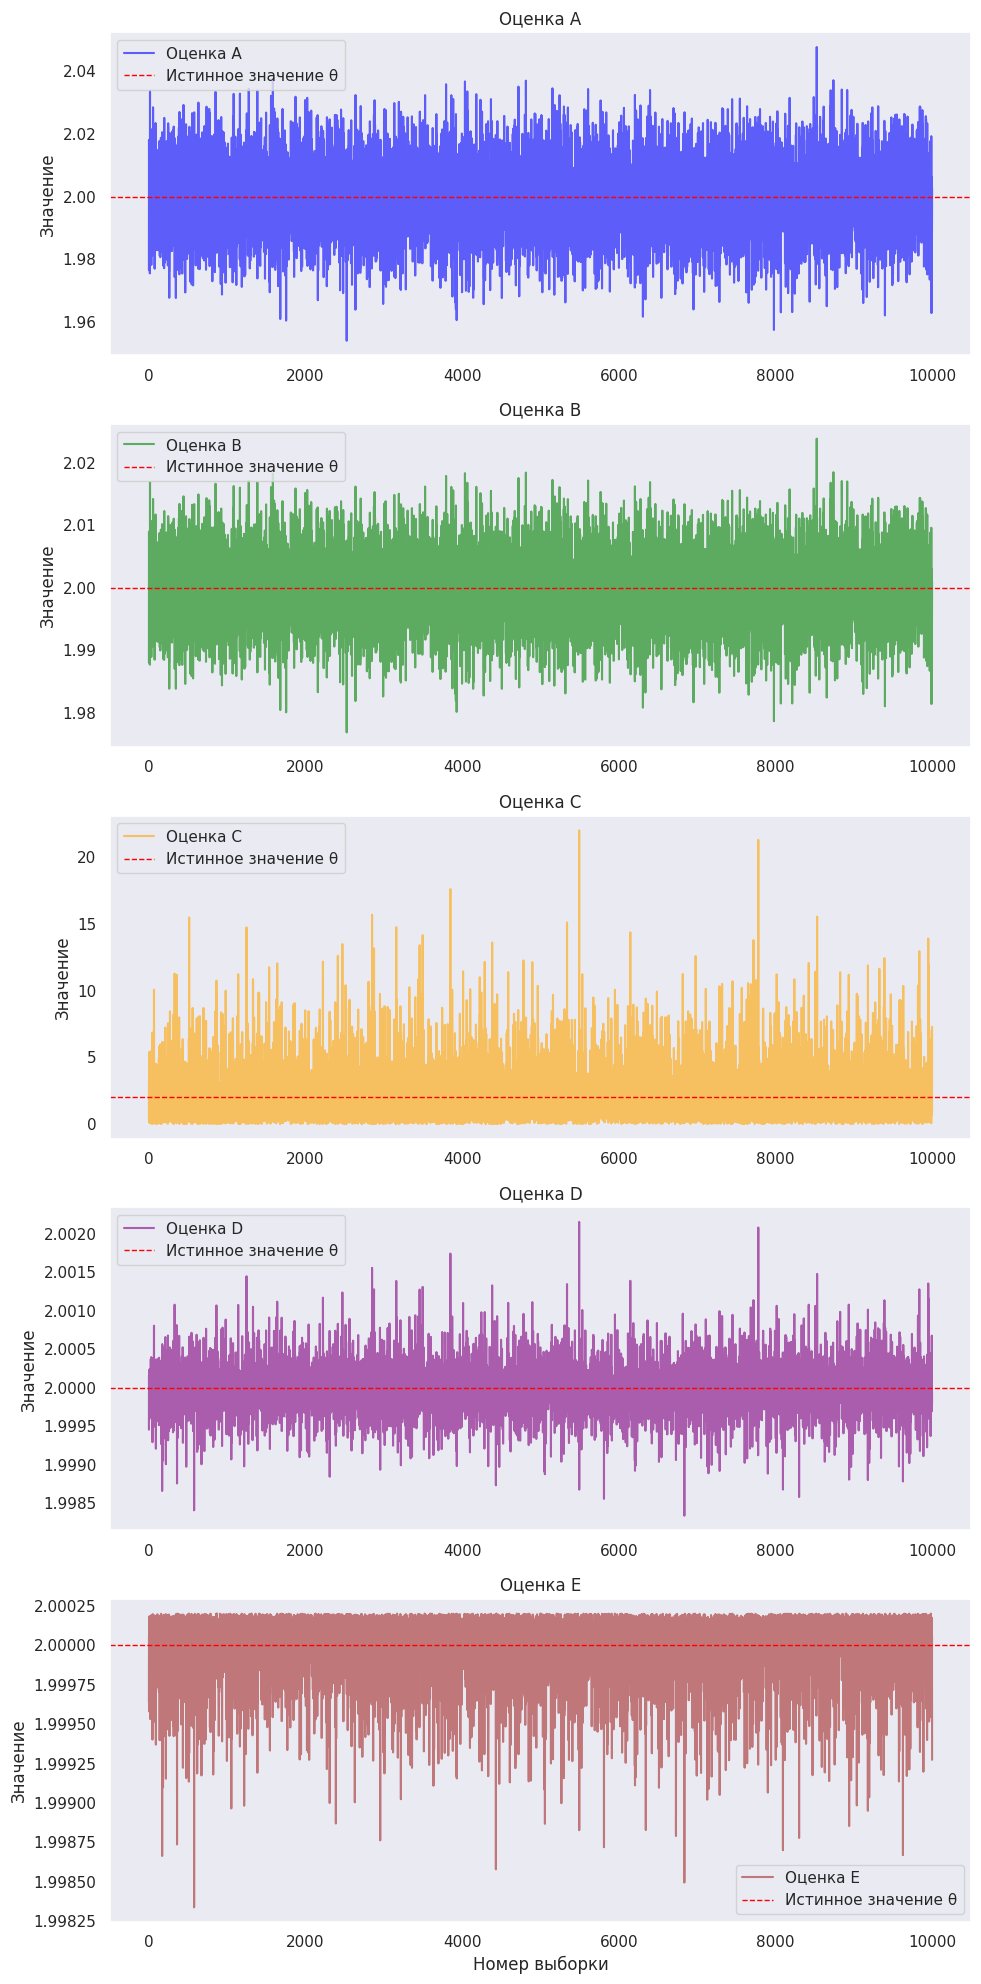

In [9]:
# Визуализация оценок на отдельных графиках
fig, axs = plt.subplots(5, 1, figsize=(10, 20))

# Оценка A
axs[0].plot(estimates_a, label='Оценка A', color='blue', alpha=0.6)
axs[0].axhline(y=theta, color='red', linestyle='dashed', linewidth=1, label='Истинное значение θ')
axs[0].set_title('Оценка A')
axs[0].set_ylabel('Значение')
axs[0].legend()
axs[0].grid()

# Оценка B
axs[1].plot(estimates_b, label='Оценка B', color='green', alpha=0.6)
axs[1].axhline(y=theta, color='red', linestyle='dashed', linewidth=1, label='Истинное значение θ')
axs[1].set_title('Оценка B')
axs[1].set_ylabel('Значение')
axs[1].legend()
axs[1].grid()

# Оценка C
axs[2].plot(estimates_c, label='Оценка C', color='orange', alpha=0.6)
axs[2].axhline(y=theta, color='red', linestyle='dashed', linewidth=1, label='Истинное значение θ')
axs[2].set_title('Оценка C')
axs[2].set_ylabel('Значение')
axs[2].legend()
axs[2].grid()

# Оценка D
axs[3].plot(estimates_d, label='Оценка D', color='purple', alpha=0.6)
axs[3].axhline(y=theta, color='red', linestyle='dashed', linewidth=1, label='Истинное значение θ')
axs[3].set_title('Оценка D')
axs[3].set_ylabel('Значение')
axs[3].legend()
axs[3].grid()

# Оценка E
axs[4].plot(estimates_e, label='Оценка E', color='brown', alpha=0.6)
axs[4].axhline(y=theta, color='red', linestyle='dashed', linewidth=1, label='Истинное значение θ')
axs[4].set_title('Оценка E')
axs[4].set_ylabel('Значение')
axs[4].legend()
axs[4].grid()

# Общие настройки графика
plt.xlabel('Номер выборки')
plt.tight_layout()
plt.show()

# Оценка смещения и дисперсии
delta = {col: np.mean(table[col]) - theta for col in table.columns}
variance = {col: np.var(table[col]) for col in table.columns}

print("Разница с тетта:", delta)
print("Дисперсия:", variance)

Разница с тетта: {'Оценка A': -8.162777364484342e-05, 'Оценка B': -0.0001403054558219985, 'Оценка C': 0.0050872618042299145, 'Оценка D': 1.505539313662041e-06, 'Оценка E': 9.969636871609566e-07}
Дисперсия: {'Оценка A': 0.0001326646423018283, 'Оценка B': 3.319482498436698e-05, 'Оценка C': 3.99022933614738, 'Оценка D': 7.894925613565379e-08, 'Оценка E': 3.8979228729626975e-08}


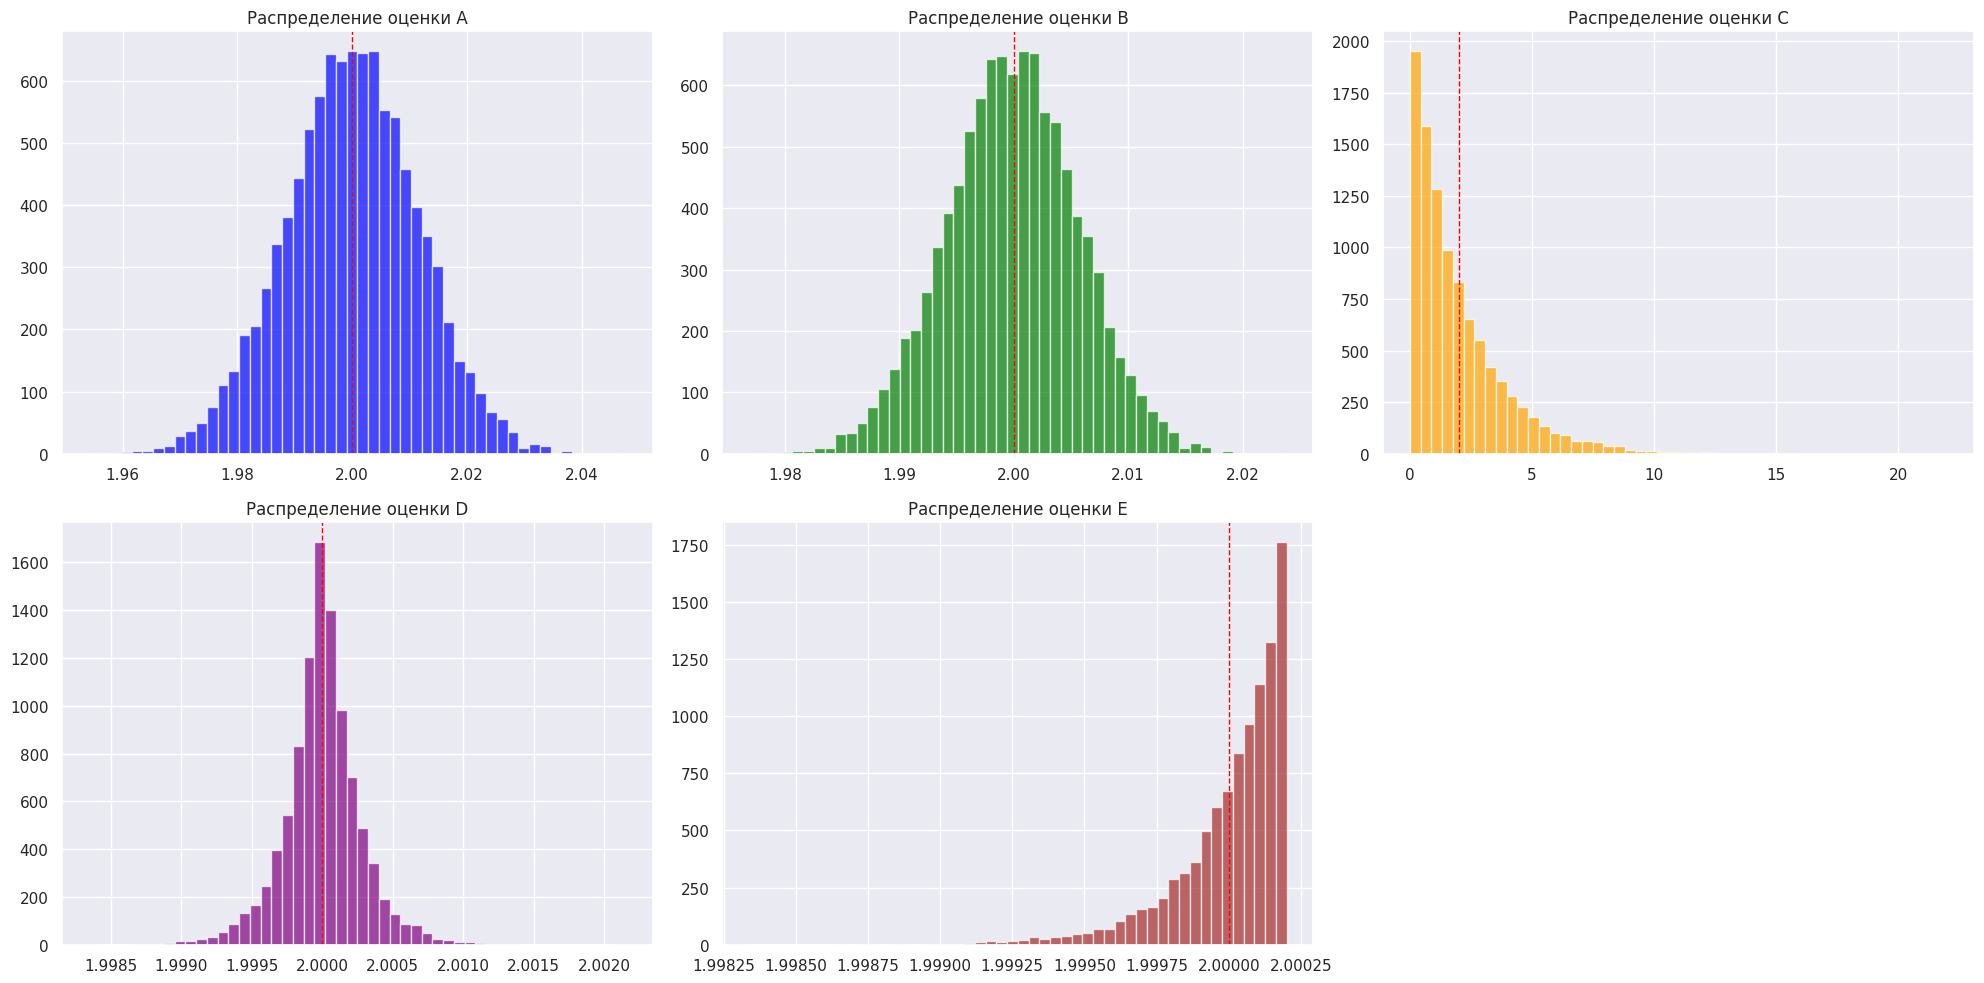

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

# Оценка A
axes[0, 0].hist(estimates_a, bins=50, color='blue', alpha=0.7)
axes[0, 0].axvline(x=theta, color='red', linestyle='dashed', linewidth=1)
axes[0, 0].set_title('Распределение оценки A')

# Оценка B
axes[0, 1].hist(estimates_b, bins=50, color='green', alpha=0.7)
axes[0, 1].axvline(x=theta, color='red', linestyle='dashed', linewidth=1)
axes[0, 1].set_title('Распределение оценки B')

# Оценка C
axes[0, 2].hist(estimates_c, bins=50, color='orange', alpha=0.7)
axes[0, 2].axvline(x=theta, color='red', linestyle='dashed', linewidth=1)
axes[0, 2].set_title('Распределение оценки C')

# Оценка D
axes[1, 0].hist(estimates_d, bins=50, color='purple', alpha=0.7)
axes[1, 0].axvline(x=theta, color='red', linestyle='dashed', linewidth=1)
axes[1, 0].set_title('Распределение оценки D')

# Оценка E
axes[1, 1].hist(estimates_e, bins=50, color='brown', alpha=0.7)
axes[1, 1].axvline(x=theta, color='red', linestyle='dashed', linewidth=1)
axes[1, 1].set_title('Распределение оценки E')

# Убираем последний пустой график
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

лучшими являются оценки D и E, ведь у оценки D разница с тетта и дисперсия, соответственно, равны 1× 10^-6 и 8× 10^-8. аналогичные параметры у оценки Е: 9.8×10^-7, 3.8×10^-8
В связи с тем, что у оценки D дисперсия меньше (то есть она более стабильная и предсказуемая, т.к. скачки минимальны), её и назовем лучшей из представленных оценок

Как меняется распределение каждой оценки с ростом параметра? Постройте оценки не только по выборкам, но и по их префиксам. В качестве размера префикса возьмите хотя бы 4 значения, меньших N.

__Подсказка:__ Могут быть полезными функции `np.arange`, `np.cumsum`, `np.maximum.accumulate` и `np.minimum.accumulate`

Изучите оценки на состоятельность и нормальность. Сравните скорости сходимости.

   Оценка A  Оценка B  Оценка C  Оценка D  Оценка E
0  1.949665  1.974734  2.954437  2.005700  2.003802
1  1.951324  1.975563  4.001250  2.003800  2.001802
2  1.966741  1.983272  2.112637  2.000858  2.000802
3  1.997002  1.998402  4.224219  2.000858  2.000302
4  1.998145  1.999012  7.391591  2.000936  2.000166
5  1.998805  1.999398  0.624451  2.000054  2.000191


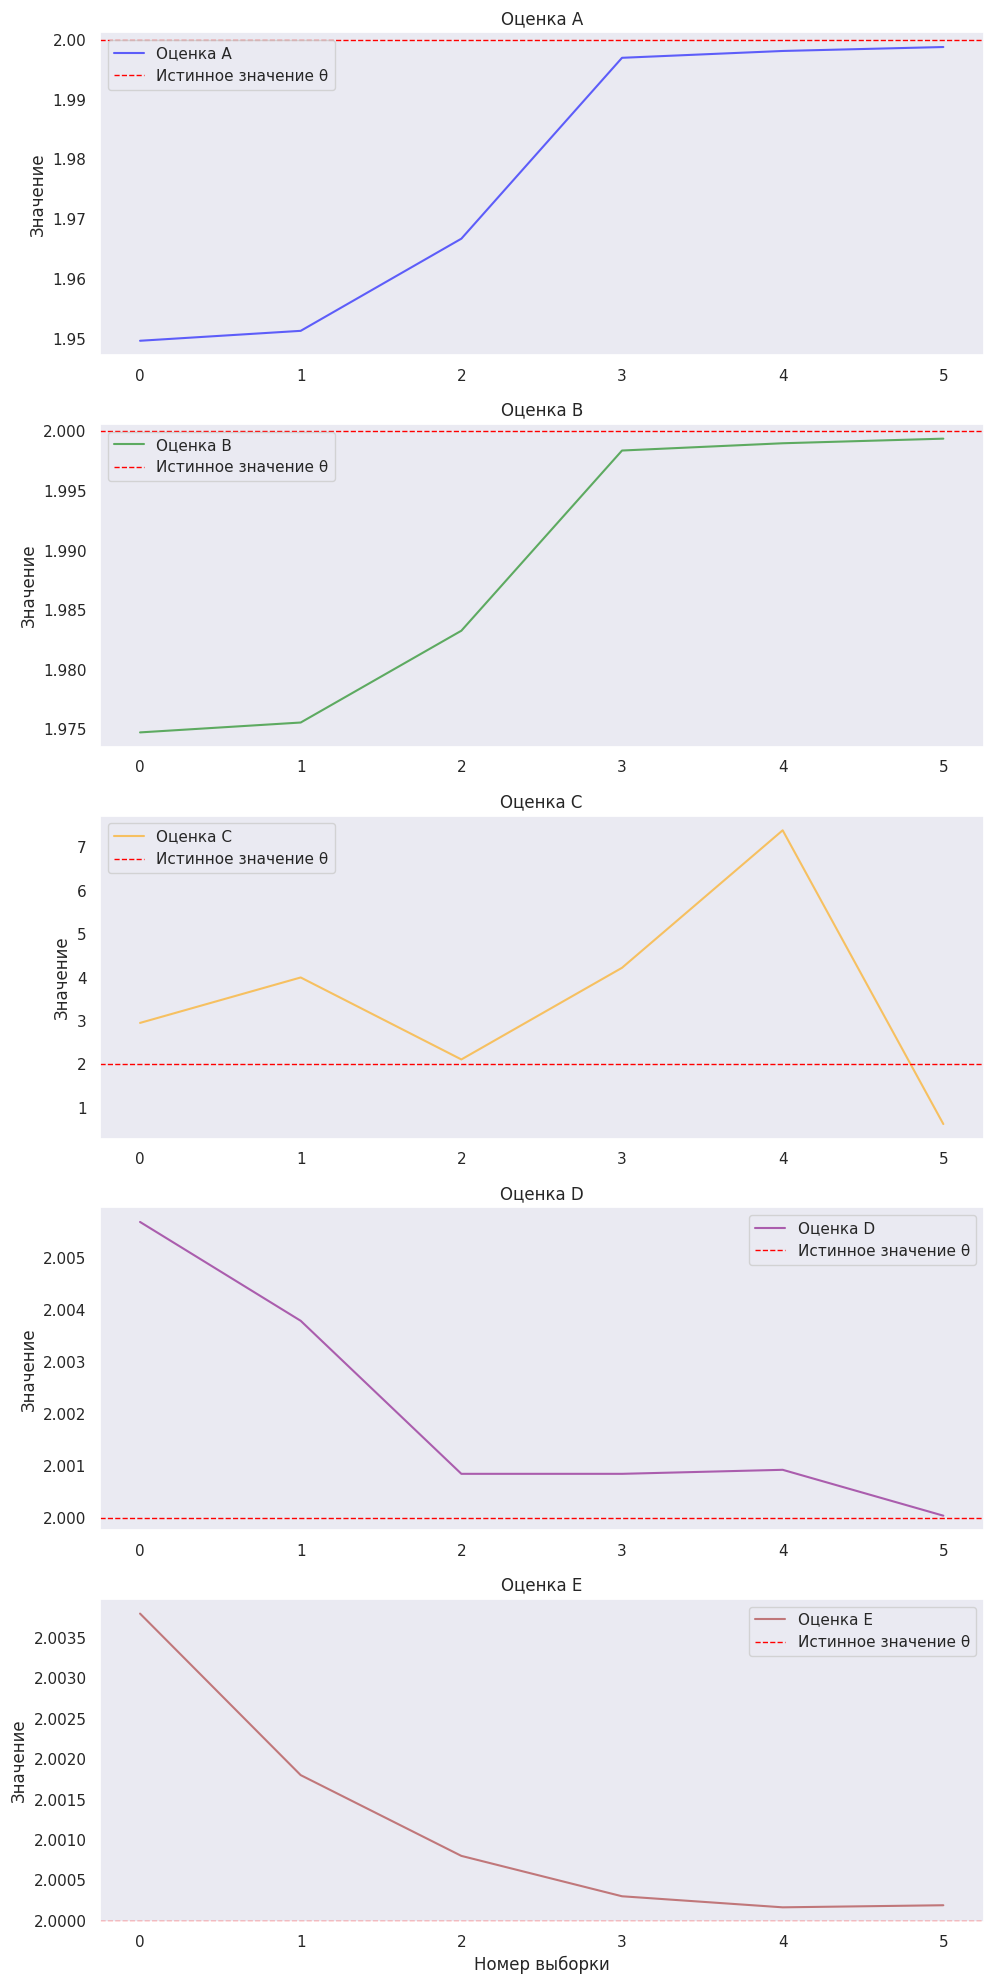

Смещение: {'Оценка A': -0.023053166684668946, 'Оценка B': -0.011603163248143256, 'Оценка C': 1.5514307881448217, 'Оценка D': 0.002034197570835783, 'Оценка E': 0.001177666104017927}
Дисперсия: {'Оценка A': 0.00047239065467311584, 'Оценка B': 0.00011857964373474502, 'Оценка C': 4.399257690233934, 'Оценка D': 4.074394851717938e-06, 'Оценка E': 1.6969613888087516e-06}


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

num_samples = int(1e4)
true_theta = 2
prefixes = np.array([500, 1000, 2000, 4000, 7000, 10000])

# Генерация выборок
samples = np.random.uniform(0, true_theta, (num_samples, num_samples))

# Оценки параметра theta
theta_estimates = [None] * 5

theta_estimates[0] = np.cumsum(samples, axis=1) * 2
theta_estimates[0] = np.take(theta_estimates[0], indices=(prefixes - 1), axis=1).T
theta_estimates[0] /= np.array([prefixes] * num_samples).T

theta_estimates[1] = np.cumsum(samples, axis=1)
theta_estimates[1] = np.take(theta_estimates[1], indices=(prefixes - 1), axis=1).T
theta_estimates[1] /= np.array([prefixes] * num_samples).T
theta_estimates[1] += np.take(np.maximum.accumulate(samples, axis=1) / 2, indices=(prefixes - 1), axis=1).T

theta_estimates[2] = np.take(np.minimum.accumulate(samples, axis=1), indices=(prefixes - 1), axis=1).T
theta_estimates[2] *= np.array([prefixes + 1] * num_samples).T

theta_estimates[3] = np.minimum.accumulate(samples, axis=1) + np.maximum.accumulate(samples, axis=1)
theta_estimates[3] = np.take(theta_estimates[3], indices=prefixes - 1, axis=1).T

theta_estimates[4] = np.maximum.accumulate(samples, axis=1)
theta_estimates[4] = np.take(theta_estimates[4], indices=prefixes - 1, axis=1).T
theta_estimates[4] *= np.array([(prefixes + 1) / prefixes] * num_samples).T

results = pd.DataFrame({
    'Оценка A': theta_estimates[0][:, -1],
    'Оценка B': theta_estimates[1][:, -1],
    'Оценка C': theta_estimates[2][:, -1],
    'Оценка D': theta_estimates[3][:, -1],
    'Оценка E': theta_estimates[4][:, -1]
})

print(results)

fig, axes = plt.subplots(5, 1, figsize=(10, 20))

# График оценки A
axes[0].plot(theta_estimates[0][:, -1], label='Оценка A', color='blue', alpha=0.6)
axes[0].axhline(y=true_theta, color='red', linestyle='--', linewidth=1, label='Истинное значение θ')
axes[0].set_title('Оценка A')
axes[0].set_ylabel('Значение')
axes[0].legend()
axes[0].grid()

# График оценки B
axes[1].plot(theta_estimates[1][:, -1], label='Оценка B', color='green', alpha=0.6)
axes[1].axhline(y=true_theta, color='red', linestyle='--', linewidth=1, label='Истинное значение θ')
axes[1].set_title('Оценка B')
axes[1].set_ylabel('Значение')
axes[1].legend()
axes[1].grid()

# График оценки C
axes[2].plot(theta_estimates[2][:, -1], label='Оценка C', color='orange', alpha=0.6)
axes[2].axhline(y=true_theta, color='red', linestyle='--', linewidth=1, label='Истинное значение θ')
axes[2].set_title('Оценка C')
axes[2].set_ylabel('Значение')
axes[2].legend()
axes[2].grid()

# График оценки D
axes[3].plot(theta_estimates[3][:, -1], label='Оценка D', color='purple', alpha=0.6)
axes[3].axhline(y=true_theta, color='red', linestyle='--', linewidth=1, label='Истинное значение θ')
axes[3].set_title('Оценка D')
axes[3].set_ylabel('Значение')
axes[3].legend()
axes[3].grid()

# График оценки E
axes[4].plot(theta_estimates[4][:, -1], label='Оценка E', color='brown', alpha=0.6)
axes[4].axhline(y=true_theta, color='red', linestyle='--', linewidth=1, label='Истинное значение θ')
axes[4].set_title('Оценка E')
axes[4].set_ylabel('Значение')
axes[4].legend()
axes[4].grid()

plt.xlabel('Номер выборки')
plt.tight_layout()
plt.show()

# Оценка смещения и дисперсии для каждой оценки
bias = {col: np.mean(results[col]) - true_theta for col in results.columns}
variance = {col: np.var(results[col]) for col in results.columns}

print("Смещение:", bias)
print("Дисперсия:", variance)


Какая оценка получилась лучше? Как Вы это поняли? А что говорит теория? Стоит ли в данной ситуации сравнивать оценки для других значений параметра $\theta$?

__Ответ:__
тут всё еще лучшими являются оценки E, D, ведь у них наименьшее отклонение от истинного значения и они к нему стремятся


Сделайте вывод.


__Вывод:__
мы получили, что лучше всего использовать оценки $X_{(1)}+X_{(n)}, \; \frac{n+1}{n} X_{(n)}$, что подтверждает теория с семинаров

### Задача 2

Конрийские провинции известны своими пастбищами и скотоводами. Принц Нерсей Пройас замерил, что количество скота подчиняется экспоненциальному распределению с параметром $\lambda = 1$ (в тысячах голов). Для подсчёта оценки параметра есть семейство оценок $(\frac{k!}{\overline{X^k}})^{\frac{1}{k}}$, каждая следующая из которых требует большего числа операций на вычисление. Стоит ли оно того? Это и нужно выяснить.

В этой задаче Вы научитесь подбирать гиперпараметр к семейству оценок. Как известно из основного курса статистики, для любого $k$ оценка  $(\frac{k!}{\overline{X^k}})^{\frac{1}{k}}$ является состоятельной и асимптотически нормальной. Но какой $k$ стоит выбрать?

Сгенерируйте $N$ выборок $X_1, ..., X_N$ размера $n$ из экспоненциального распределения с параметром $\lambda = 1$ для $N = n = 10^4$.

In [12]:
N = int(1e4)
n = int(1e4)
lambda_true = 1

samples = np.random.exponential(scale=1/lambda_true, size=(N, n))

Для всех выборок посчитайте оценку $\widehat{\lambda}_k=(\frac{k!}{\overline{X^k}})^{\frac{1}{k}}$ параметра $\lambda$. Проведите исследование, аналогичное предыдущей задаче, и выясните, при каком k оценка ведет себя лучше (рассмотрите не менее $10$ различных значений $k$).

In [13]:
from math import factorial
def lambda_hat_k(k, sample_means):
    return (factorial(k) / sample_means) ** (1 / k)

k_params = np.array([1, 2, 3, 4, 5, 7, 10, 15, 20, 50])
lambdas = []

for k in k_params:
    sample_means = np.mean(samples ** k, axis=1)
    lambdas.append(lambda_hat_k(k, sample_means))

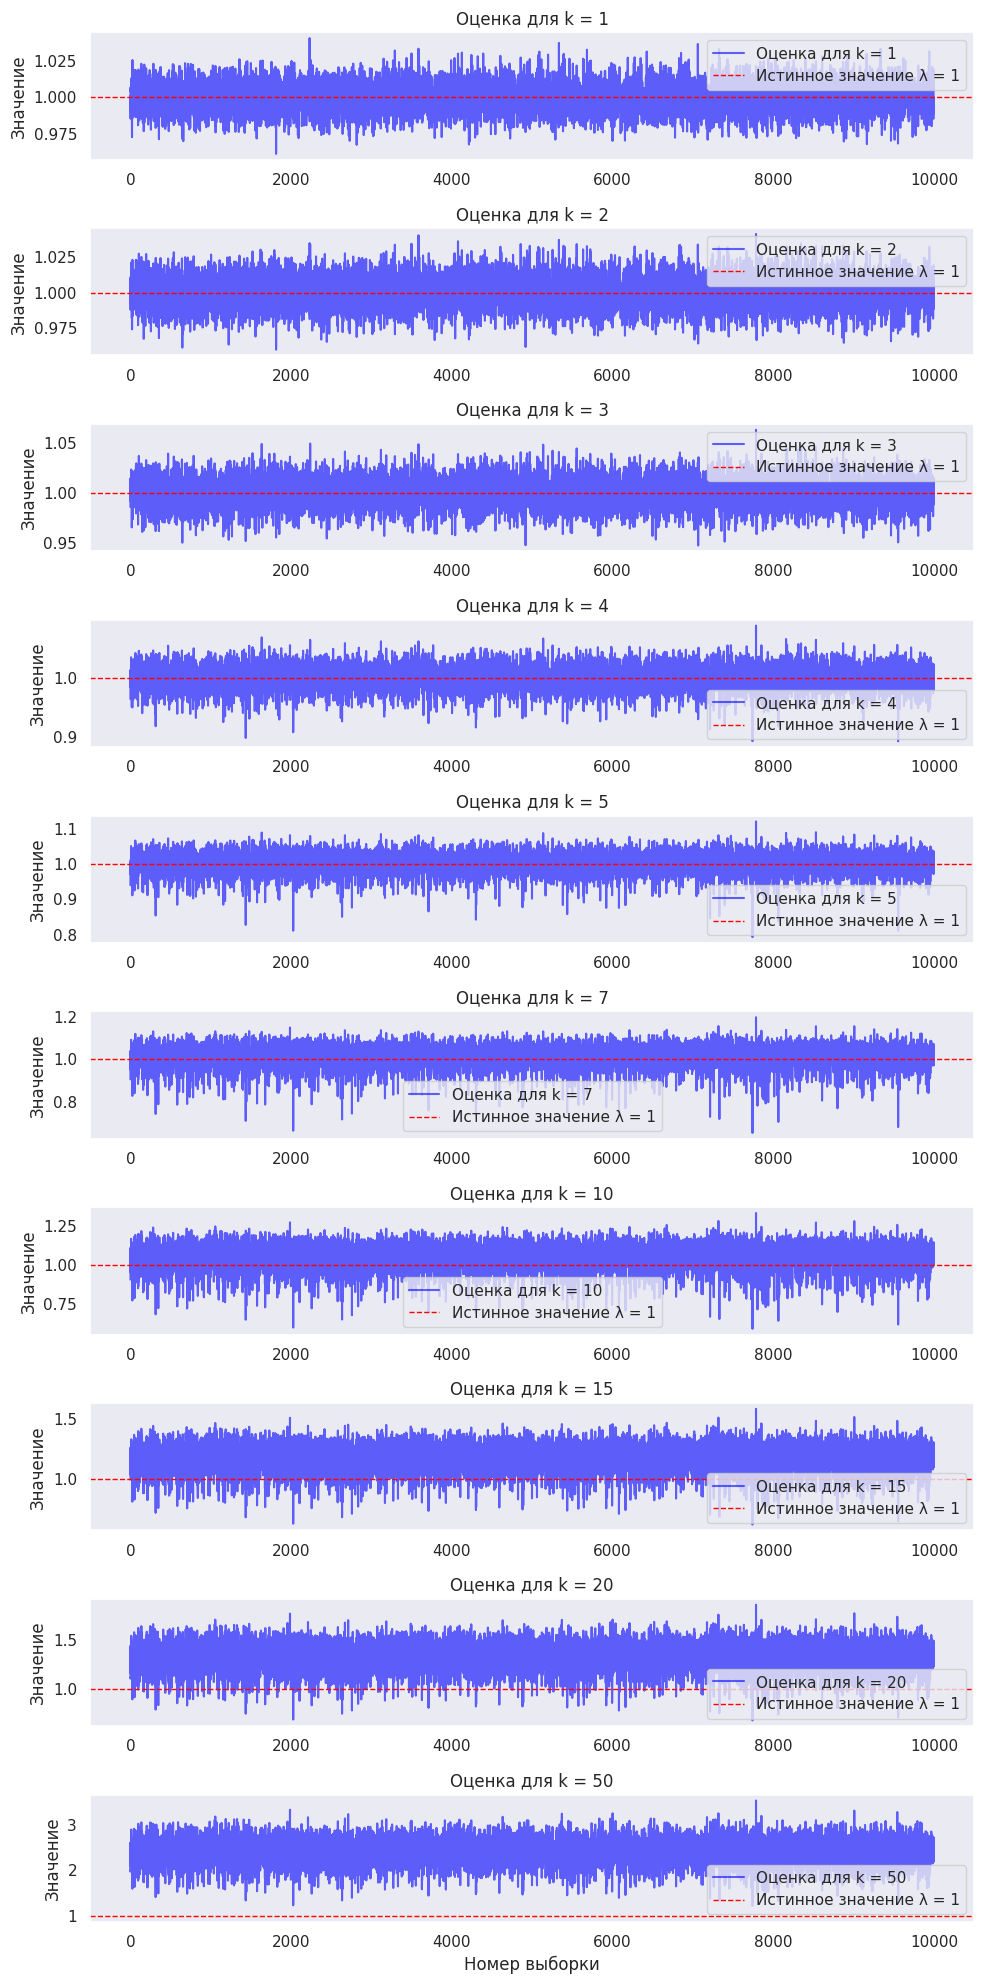

Смещение: {'k = 1': -4.75182062096291e-05, 'k = 2': 1.2049138431446949e-06, 'k = 3': 0.0001242992411163435, 'k = 4': 0.0005979966851823448, 'k = 5': 0.0020468321564102165, 'k = 7': 0.01204691719143769, 'k = 10': 0.053329494818684875, 'k = 15': 0.17587931703802817, 'k = 20': 0.33146827843947846, 'k = 50': 1.4179228722599695}
Дисперсия: {'k = 1': 9.879742020720354e-05, 'k = 2': 0.00012157060751493513, 'k = 3': 0.0002040333632210009, 'k = 4': 0.0004089241317273988, 'k = 5': 0.0008540986557420458, 'k = 7': 0.002695479419521556, 'k = 10': 0.006674048939466253, 'k = 15': 0.013495607638474716, 'k = 20': 0.020557594349663928, 'k = 50': 0.08192329032933236}


In [14]:
fig, axes = plt.subplots(len(k_params), 1, figsize=(10, 20))
for i in range(len(k_params)):
    axes[i].plot(lambdas[i], label='Оценка для k = ' + str(k_params[i]), color='blue', alpha=0.6)
    axes[i].axhline(y=lambda_true, color='red', linestyle='--', linewidth=1, label='Истинное значение λ = 1')
    axes[i].set_title('Оценка для k = ' + str(k_params[i]))
    axes[i].set_ylabel('Значение')
    axes[i].legend()
    axes[i].grid()

plt.xlabel('Номер выборки')
plt.tight_layout()
plt.show()

bias = {f'k = {k}': np.mean(lambdas[i]) - lambda_true for i, k in enumerate(k_params)}
variance = {f'k = {k}': np.var(lambdas[i]) for i, k in enumerate(k_params)}

print("Смещение:", bias)
print("Дисперсия:", variance)

тут уже видно что чем менбше параметр к, тем меньше будет отклонение от истинного значения

Являются ли данные оценки асимптотически нормальными? Проверьте это теоретически и моделированием -- постройте эмпирическую плотность распределения статистик $\sqrt{n}\left(\widehat\lambda_k - \lambda\right)$.

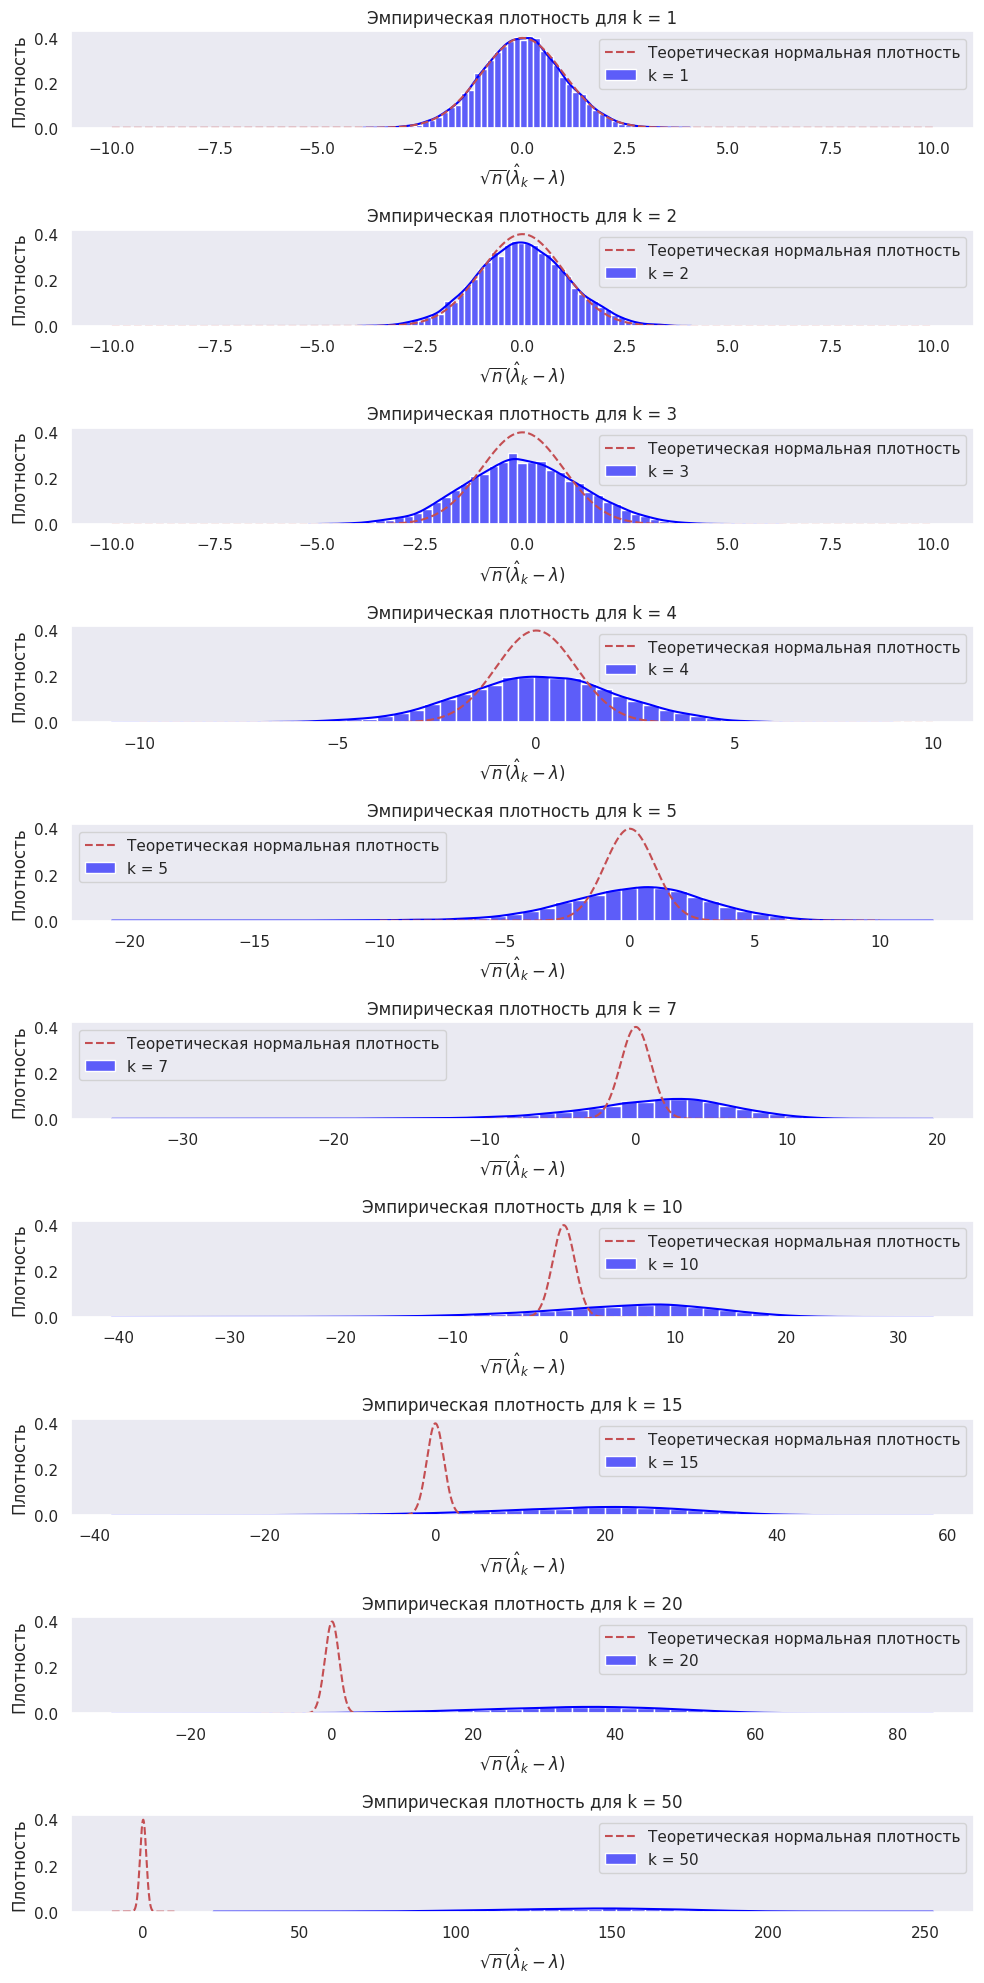

In [15]:
scaled_stats = [np.sqrt(n) * (lambdas[i] - lambda_true) for i in range(len(k_params))]

fig, axes = plt.subplots(len(k_params), 1, figsize=(10, 20))
x_vals = np.linspace(-10, 10, 1000)

for i, k in enumerate(k_params):
    sns.histplot(scaled_stats[i], bins=50, kde=True, color='blue', stat='density', ax=axes[i], label=f'k = {k}', alpha=0.6)
    axes[i].plot(x_vals, norm.pdf(x_vals, 0, 1), 'r--', label='Теоретическая нормальная плотность')
    axes[i].set_title(f'Эмпирическая плотность для k = {k}')
    axes[i].set_xlabel(r'$\sqrt{n}(\hat{\lambda}_k - \lambda)$')
    axes[i].set_ylabel('Плотность')
    axes[i].legend()
    axes[i].grid()

plt.tight_layout()
plt.show()

в теории они все являются асимптотически нормальными. они все имеют плотность, похожую на нормальную, но центрированны верно только оценки с k=1,2,3,4

Посчитайте дисперсию оценок для разных $k$ и разных размеров выборки. Сходится ли она к теоретической? Что Вы можете сказать о скорости сходимости?

на семинаре мы нашли теоретическую дисперсию: $\frac{(2k)! - (k!)^2}{k^2(k!)^2}\lambda^2$

In [27]:
theoretical_variances = {}
for k in k_params:
    factorial_2k = math.factorial(2 * k)
    factorial_k_squared = math.factorial(k) ** 2

    variance = (factorial_2k - factorial_k_squared) / (k**2 * factorial_k_squared) * (1 ** 2)
    theoretical_variances[f'k = {k}'] = variance

print("Теоретическая дисперсия для различных k:")
for k, var in theoretical_variances.items():
    print(f"{k}: {var:.5f}")

Теоретическая дисперсия для различных k:
k = 1: 1.00000
k = 2: 1.25000
k = 3: 2.11111
k = 4: 4.31250
k = 5: 10.04000
k = 7: 70.02041
k = 10: 1847.55000
k = 15: 689411.19556
k = 20: 344616322.04750
k = 50: 40356537818225677420199936.00000


In [16]:
n = 10000
plt.figure(figsize=(12, 8))

for i, k in enumerate(k_params):
    sample_means = np.mean(samples ** k, axis=1)
    lambdas = (factorial(k) / sample_means) ** (1 / k)

    sns.kdeplot(lambdas, label=f'k = {k}')
plt.title('Графики KDE для оценок λ_k при разных значениях k, n = 10000')
plt.xlabel('Оценка λ')
plt.ylabel('Плотность')
plt.grid()
plt.legend()
plt.tight_layout()

plt.show()

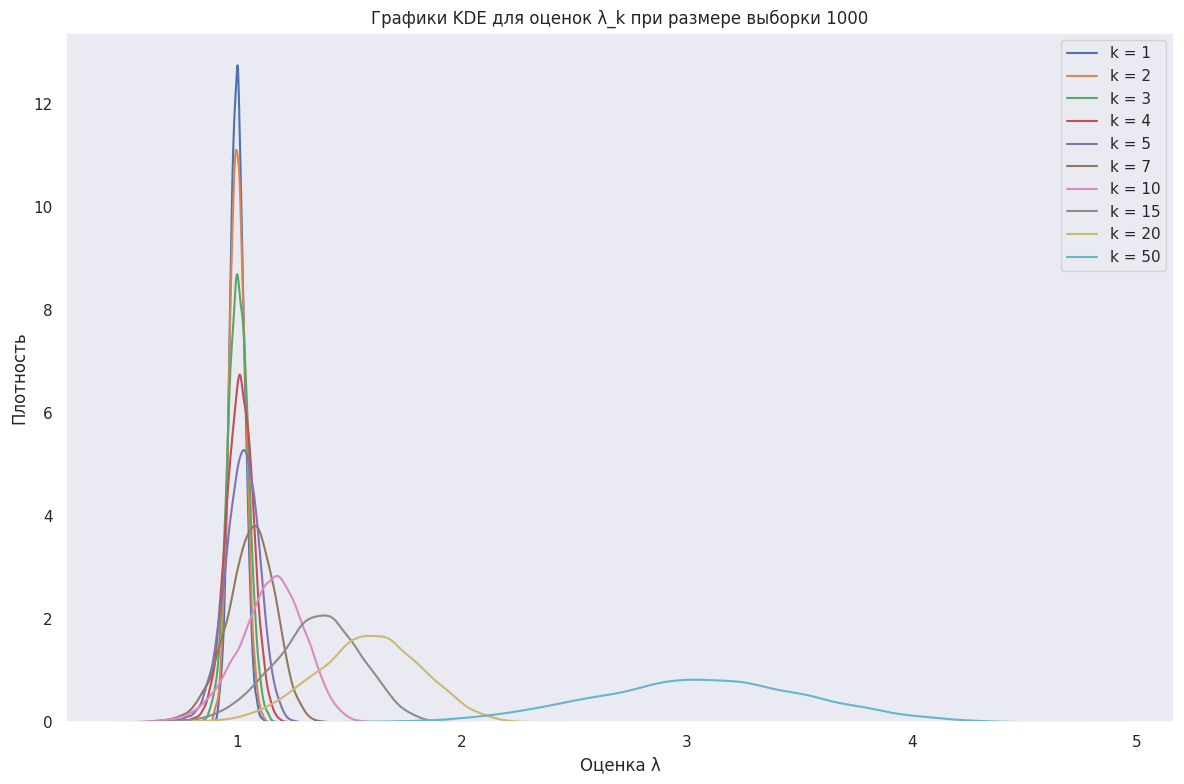

In [17]:
n_small = 1000
samples_small = np.random.exponential(scale=1/lambda_true, size=(N, n_small))

plt.figure(figsize=(12, 8))

for i, k in enumerate(k_params):
    sample_means = np.mean(samples_small ** k, axis=1)
    lambdas = (factorial(k) / sample_means) ** (1 / k)

    sns.kdeplot(lambdas, label=f'k = {k}')

plt.title('Графики KDE для оценок λ_k при размере выборки 1000')
plt.xlabel('Оценка λ')
plt.ylabel('Плотность')
plt.grid()
plt.legend()
plt.tight_layout()

plt.show()

In [18]:
n_extrasmall = 100
samples_small = np.random.exponential(scale=1/lambda_true, size=(N, n_extrasmall))

plt.figure(figsize=(12, 8))

for i, k in enumerate(k_params):
    sample_means = np.mean(samples_small ** k, axis=1)
    lambdas = (factorial(k) / sample_means) ** (1 / k)

    sns.kdeplot(lambdas, label=f'k = {k}')

plt.title('Графики KDE для оценок λ_k при размере выборки 100')
plt.xlabel('Оценка λ')
plt.ylabel('Плотность')
plt.grid()
plt.legend()
plt.tight_layout()

plt.show()

заметим, что чем меньше к, тем меньше дисперсия. поэтому для дальнейшего опыта выберем значение к = 1

с ростом выборки ситуация противоположна: при увеличении размера, дисперсия уменьшается




Для одной выборки постройте графики $\left|\hat{\lambda}_k - \lambda\right|$ и сравните скорости сходимости к нулю при увеличении размера выборки.

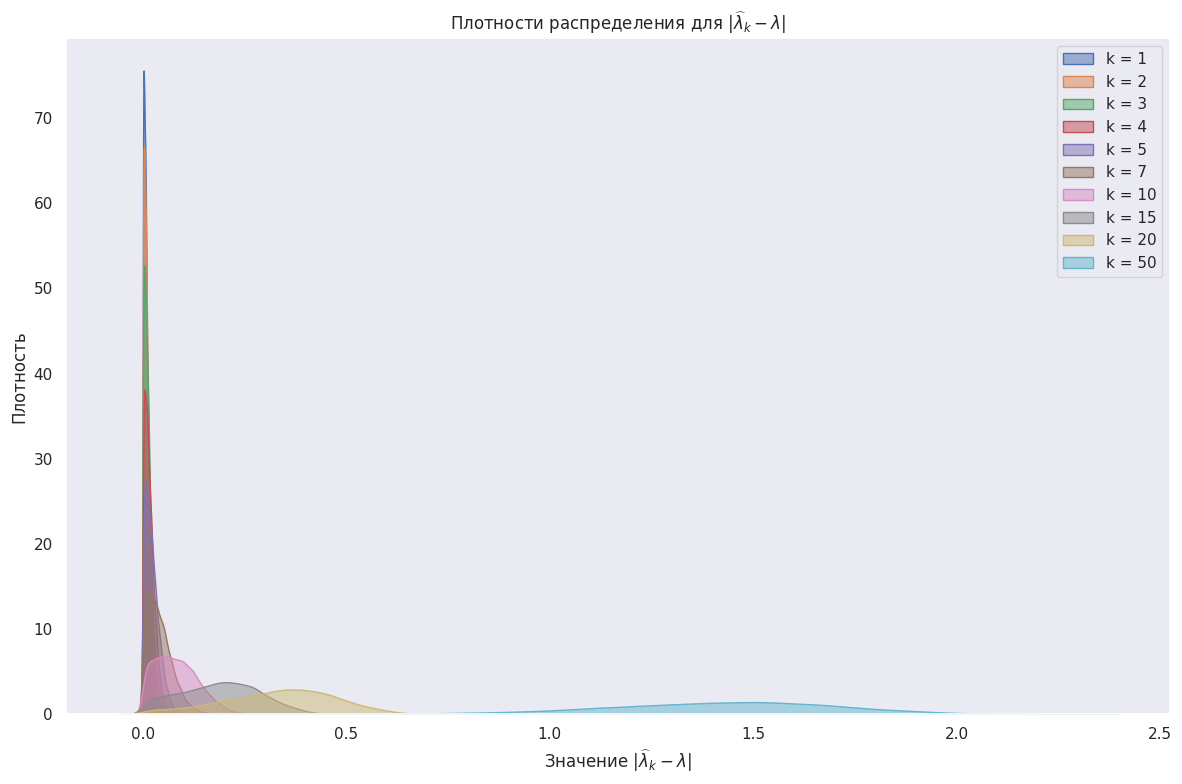

In [25]:
import math
X = np.random.exponential(scale=1, size=(N, n))

plt.figure(figsize=(12, 8))

for i in k_params:
    fact = math.factorial(i)
    new_X = np.mean(X ** i, axis=1)
    est = (fact / new_X) ** (1/i)
    error = abs(est - 1)
    sns.kdeplot(error, label=f'k = {i}', fill=True, alpha=0.5)

plt.title('Плотности распределения для |$\widehat{\lambda}_k - \lambda$|')
plt.xlabel("Значение |$\widehat{\lambda}_k - \lambda$|")
plt.ylabel("Плотность")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

Сделайте вывод.


__Вывод:__
все исследования подтвердили, что наилучший параметр - к=1, т.к. при нем наблюдается наименьшая дисперсия (как практическая, так и теоретическая) и график при таком выборе быстрее всех стремится к нулю

также стоит отметить очевидный но важный факт: нужно брать выборки как можно больше для корректных выводов об оценках

### Задача 3

Кианские провинции до сих пор надеются отделиться от Новой Империи, и поэтому планируют саботировать Ордалию. К их счастью, число урожая в пустынных землях на юге подчиняется распределению Коши, которое отличается существенно от двух распределений из задач 1 и 2. Чем отличается? Как это повлияет на оценивание его параметра сдвига?

В этой задаче Вам нужно показать на примере, как построение интуитивно понятной оценки без теоретического обоснования может дать неадекватный результат.

Ниже напишите, какое поведение Вы ожидаете от оценки среднего и медианы. Обоснуйте ожидания, ссылаясь на теоремы и задачи из курса теории вероятностей:

Ответ:

Для распределения Коши моделированием изучите поведение оценки параметра сдвига при помощи среднего и медианы. У какой из этих оценок лучше асимптотические свойства?

In [17]:
N = 10000
n = 10000
theta = 100

samples = sps.cauchy.rvs(loc=theta, scale=1, size=(N, n))

average = np.mean(samples, axis=1)
median = np.median(samples, axis=1)

Проверьте свои теоретические ожидания, написанные в начале задачи. Моделированием проверьте, какие оценки состоятельны и асимптотически нормальны.

In [18]:
def plot_density(average, median, theta):
    plt.figure(figsize=(15, 6))

    plt.subplot(1, 2, 1)
    x_mean = np.linspace(theta - 50, theta + 50, 1000)
    kde_mean = sps.gaussian_kde(average)
    plt.plot(x_mean, kde_mean(x_mean), color='red', linewidth=2, label=r"$\overline{X}$")
    plt.axvline(theta, color='black', linestyle='--', label='Истинное значение θ')
    plt.title('Плотность распределения среднего')
    plt.xlabel("Значение θ")
    plt.ylabel("Плотность")
    plt.legend()

    plt.subplot(1, 2, 2)
    x_median = np.linspace(theta - 2, theta + 2, 1000)
    kde_median = sps.gaussian_kde(median)
    plt.plot(x_median, kde_median(x_median), color='blue', linewidth=2, label=r"$X_{(\frac{1}{2})}$")
    plt.axvline(theta, color='black', linestyle='--', label='Истинное значение θ')
    plt.title('Плотность распределения медианы')
    plt.xlabel("Значение θ")
    plt.ylabel("Плотность")
    plt.legend()

    plt.suptitle(r'Плотность распределения оценок $\overline{X}$ и $X_{(\frac{1}{2})}$ для параметра смещения в распределении Коши')
    plt.tight_layout()
    plt.show()

In [25]:
plot_density(average, median, theta)

кажется, будто медиана справляется лучше. там график уже и разброс меньше

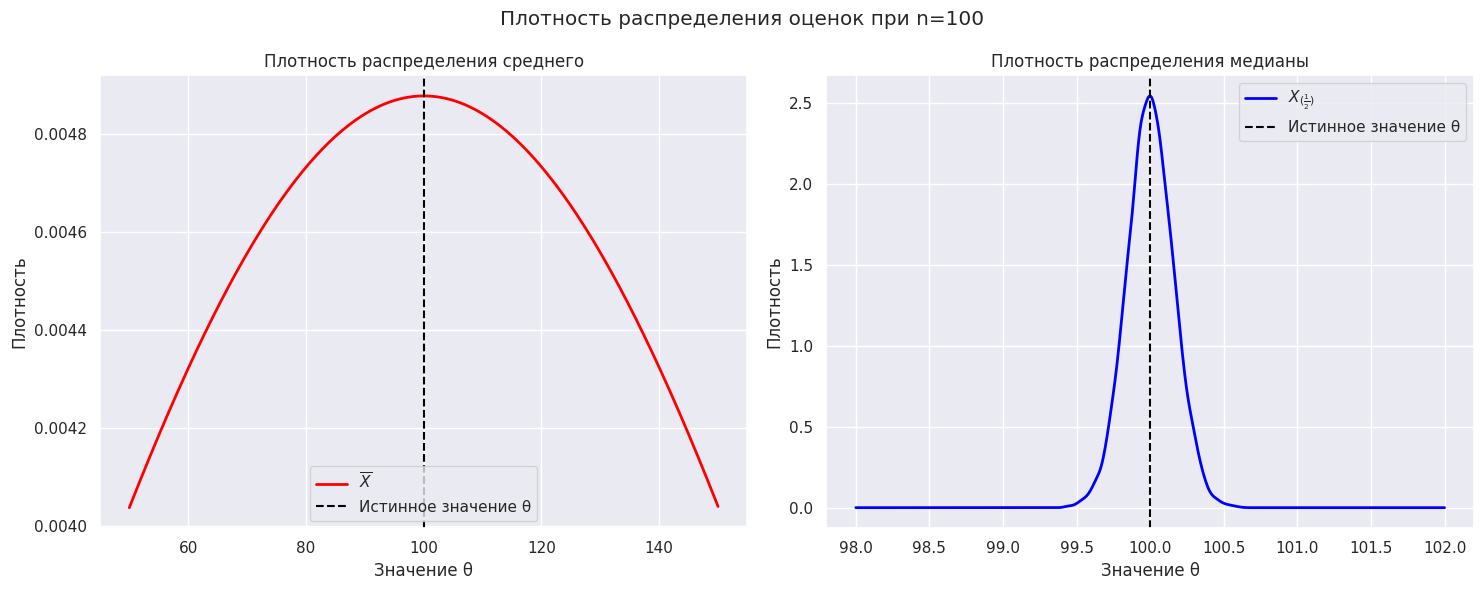

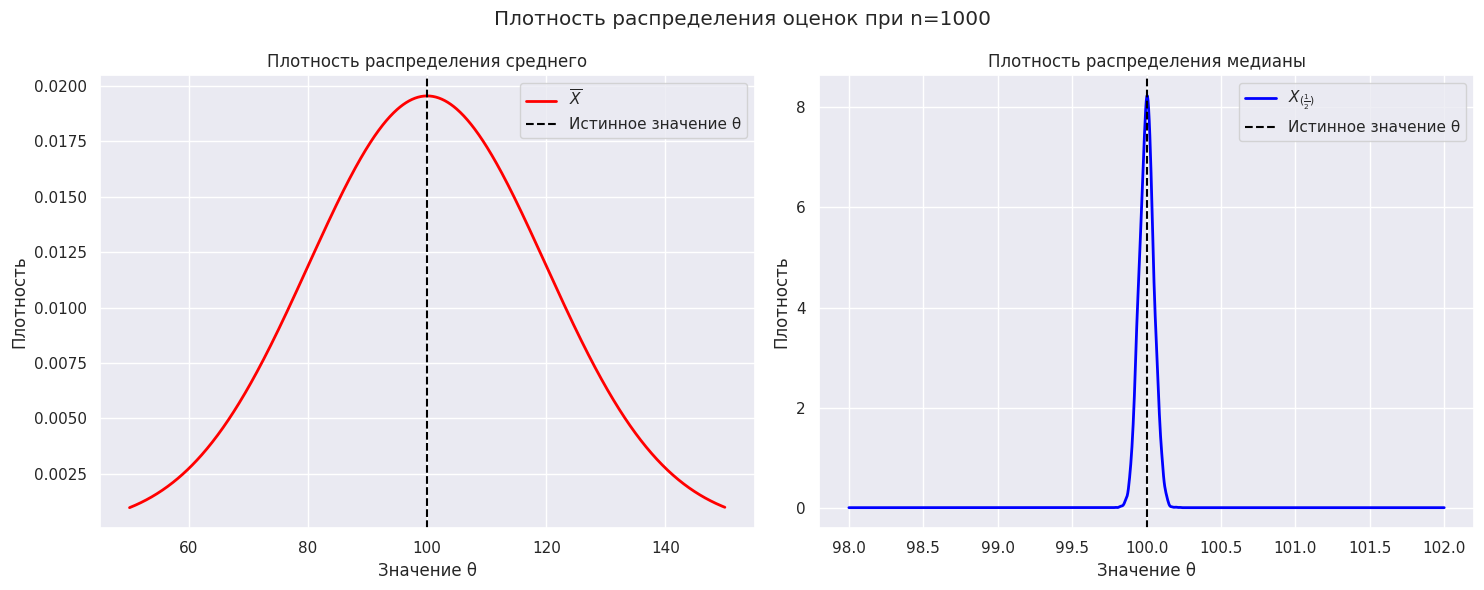

In [26]:
theta = 10
N = 10000
ns = [10, 100, 1000]
theta = 100
for n in (ns):
  samples = sps.cauchy.rvs(loc=theta, scale=1, size=(N, n))
  average = np.mean(samples, axis=1)
  median = np.median(samples, axis=1)
  plot_density(average, median, theta)


оценки выглядят состоятельныи, ведь графики сужаются с ростом размера выборки. также они асимптотически нормальные, ведь визуально имеют нормальное распределение

Изучите поведение эмпирической дисперсии оценок среднего и медианы. Какая из них сходится? С какой скоростью? Для проверки постройте график какой-то детерминированной функции с такой же скоростью сходимости.

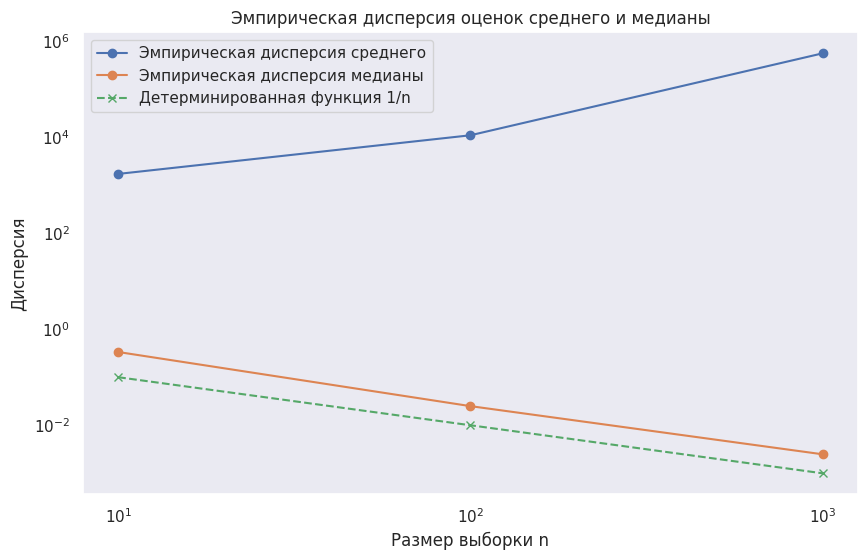

In [28]:
theta = 10
N = 10000
ns = [10, 100, 1000]
theta = 100
var_average = []
var_median = []
for n in (ns):
  samples = sps.cauchy.rvs(loc=theta, scale=1, size=(N, n))
  average = np.mean(samples, axis=1)
  median = np.median(samples, axis=1)
  var_average.append(np.var(average))
  var_median.append(np.var(median))

plt.figure(figsize=(10, 6))
plt.plot(ns, var_average, marker='o', label='Эмпирическая дисперсия среднего')
plt.plot(ns, var_median, marker='o', label='Эмпирическая дисперсия медианы')

deterministic_function = [1/n for n in ns]
plt.plot(ns, deterministic_function, marker='x', label='Детерминированная функция 1/n', linestyle='--')

plt.xscale('log')
plt.yscale('log')
plt.title('Эмпирическая дисперсия оценок среднего и медианы')
plt.xlabel('Размер выборки n')
plt.ylabel('Дисперсия')
plt.legend()
plt.grid()
plt.show()

**Вывод:**
опять же заметно, что медиана намного лучше. она стремится к нулю очень быстро (как 1/n)

### Задача 4

Древние свитки из Сареотской библиотеки хранят знания двух древних волшебников севера --- Гливенко и Кантелли. Два мага-гностика придумали ультимативный способ оценивания распределений количества чего угодно. Их способом пользовались короли севера ещё две тысячи лет назад, во времена Первой Ордалии. Аспект-Император отдал приказ проверить, верны ли их выкладки до сих пор.

Эта задача посвящена проверке теоремы Гливенко-Кантелли, как основного теоретического результата курса. Условия посмотрите в методичке или сходите на лекцию старшего магистра колдовства и чародейства Савёлова М.П.

Сгенерируйте $N$ выборок $X_1,\dots, X_N$ размера $N$ из стандартного нормального распределения для $N = 10^4$.

In [16]:
np.random.seed(42)
N = int(1e4)
X = sps.norm(0,1).rvs((N, N))

Для всех $n \leqslant N$ первой выборки посчитайте эмпирическую функцию распределения.


In [17]:
from statsmodels.distributions.empirical_distribution import ECDF  # can be useful, but not necessary

first_sample = X[0, :]
ecdfs = [ECDF(first_sample[:i]) for i in range(1, N + 1)]

value = 0
for i, ecdf in enumerate(ecdfs, 1):
    if i % 1000 == 0:
        print(f'n = {i}, ECDF({value}) = {ecdf(value)}')

n = 1000, ECDF(0) = 0.49
n = 2000, ECDF(0) = 0.4835
n = 3000, ECDF(0) = 0.489
n = 4000, ECDF(0) = 0.49174999999999996
n = 5000, ECDF(0) = 0.4948
n = 6000, ECDF(0) = 0.49866666666666665
n = 7000, ECDF(0) = 0.5027142857142857
n = 8000, ECDF(0) = 0.502
n = 9000, ECDF(0) = 0.5011111111111111
n = 10000, ECDF(0) = 0.5008


Для некоторых $n$ (например, $n \in \{10,25,50,100,1000,N\}$ постройте графики эмпирической функции распределения (отметьте на оси абсцисс точки "скачков" кривых, нанеся каждую из "подвыборок" на ось абсцисс на каждом соответствующем графике с коэффициентом прозрачности `alpha=0.2`) и сравните каждый из них с истинной функцией распределения (количество графиков равно количеству различных значений $n$).

Проверьте выполнение теоремы Гливенко-Кантелли.

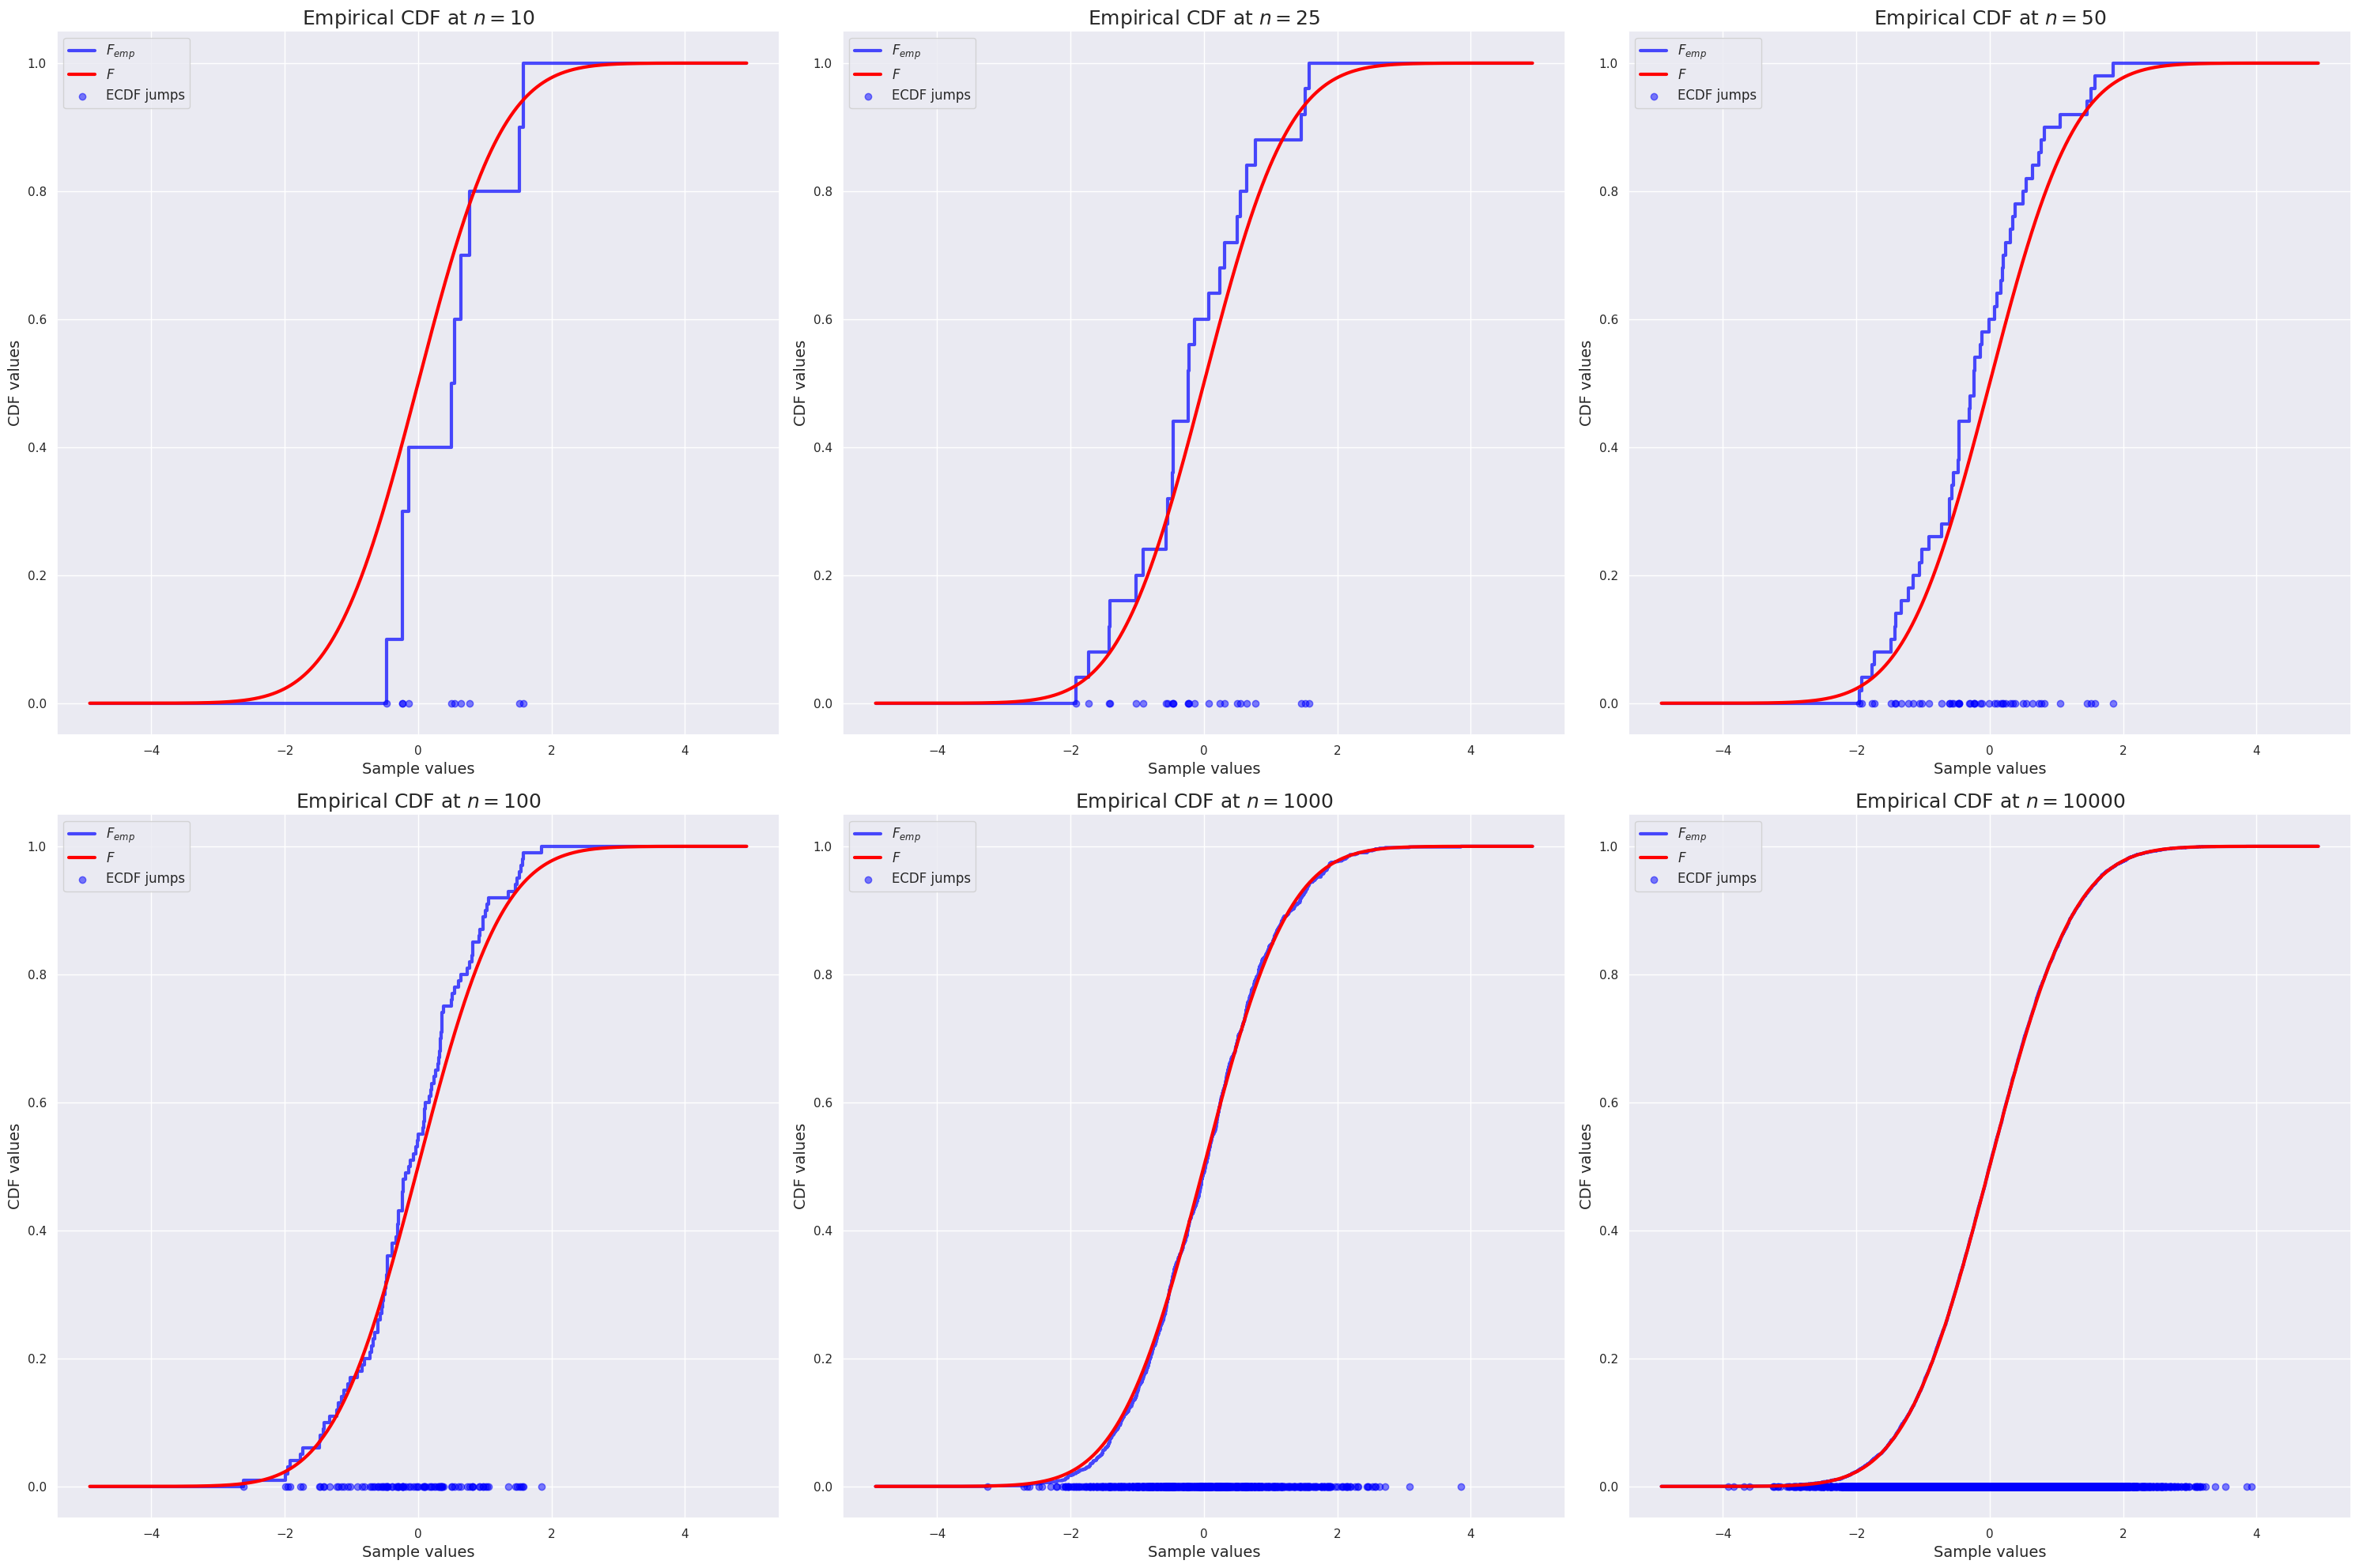

In [18]:
sample_sizes = [10, 25, 50, 100, 1000, N]
xmin = first_sample.min() - 1
xmax = first_sample.max() + 1
x_values = np.linspace(xmin, xmax, 1000)

def plot_ecdf(n, ax):
    F_emp = ecdfs[n - 1]
    ax.set_title(r"Empirical CDF at $n = {}$".format(n), fontsize=18)
    ax.set_xlabel("Sample values", fontsize=14)
    ax.set_ylabel("CDF values", fontsize=14)
    ax.step(np.sort(np.append([xmin, xmax], first_sample[:n])),
            F_emp(np.sort(np.append([xmin, xmax], first_sample[:n]))),
            alpha=0.7, color='blue', label=r'$F_{emp}$', where='post', linewidth=3)
    ax.plot(x_values, sps.norm(0, 1).cdf(x_values), color='red', label=r'$F$', linewidth=3)
    ax.scatter(np.sort(first_sample[:n]), np.zeros(n), color='blue', alpha=0.5, label=r'ECDF jumps')
    ax.legend(fontsize=12)

fig, axs = plt.subplots(2, 3, figsize=(30, 20))

for i, n in enumerate(sample_sizes):
    plot_ecdf(n, axs[i // 3, i % 3])

plt.tight_layout()
plt.show()


Графики показывают, что с увеличением
𝑛 эмпирическая функция распределения (синяя) сходится к истинной функции (красная). Для больших
𝑛 различия почти исчезают, подтверждая выполнение теоремы Гливенко-Кантелли. Таким образом, эмпирическая CDF приближается к истинной с увеличением объема выборки.

Для всех $n ≤ N$ посчитайте значение $D_n = \displaystyle{\sup_{x \in \mathbb R}} | \hat{F}_n(x) - F(x)|$ для первой выборки. Промоделируйте поведение статистики $\sqrt{n}D_n$. Наблюдается ли сходимость их распределений на графиках?


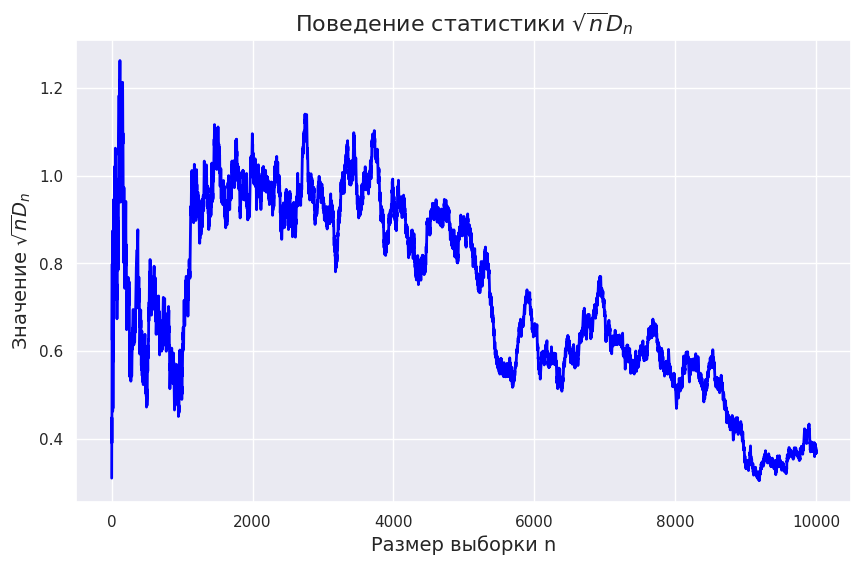

In [19]:
D_n_values = [np.max(np.abs(ecdfs[i](np.sort(first_sample[:i+1])) - sps.norm.cdf(np.sort(first_sample[:i+1]))))
              for i in range(N)]

sqrt_n_D_n_values = [np.sqrt(i + 1) * D_n_values[i] for i in range(N)]

plt.figure(figsize=(10, 6))
plt.plot(np.linspace(1, N, N), sqrt_n_D_n_values, color='blue', linewidth=2)
plt.title(r'Поведение статистики $\sqrt{n}D_n$', fontsize=16)
plt.ylabel(r'Значение $\sqrt{n}D_n$', fontsize=14)
plt.xlabel("Размер выборки n", fontsize=14)
plt.grid(True)
plt.show()


Пища для ума: если Ваша эмпирическая плотность сходится к чему-то, то это не просто так! Поищите на просторах интернета, учебников и бесед с умными людьми, куда должна сходиться статистика $\sqrt{n}D_n$. Подумайте, для чего может быть полезен этот теоретический результат.

Ответ:
порыскав в интернете, я нашел, что распределение $\sqrt{n} D_n$ стремится к распределению Колмогорова, которое имеет распределение, визуально похожее на полученное.
Теорема Гливенко-Кантелли позволяет использовать статистику
$\sqrt{n} D_n$ для проверки гипотез о соответствии эмпирического распределения теоретическому. Это важно для оценки моделей и повышения надежности статистических выводов.


Сделайте вывод о важности теоремы Гливенко-Кантелли в численном анализе. Какие методы, применяемые Вами в других задачах неявно основываются на этой теореме?

**Вывод:**
Теорема Гливенко-Кантелли гарантирует сходимость эмпирических распределений к истинному при увеличении объёма выборки


### Задача 5

Оказывается, нельзя оценивать распределения оценок на глаз простым всматриванием в графики! Поэтому гностики из крепости Нрон изобрели новое заклинание -- QQ-plot. В этой задаче Вам предстоит научиться проверять распределения на принадлежность семействам при помощи этого инструмента.

В этой задаче Вам предлагается изучить инструмент QQ-plot и сделать на его основе выводы о равенстве распределений.

Сгенерируйте $N_{\text{samples}}=400$ выборок из равномерного распределения $\mathrm U{[0, \theta]}$ для $\theta=1$ размера $n=40$. Моделированием статистик $\hat\theta = 2\overline{X}, \ \theta^* = \frac{n+1}{n} X_{(n)}$ изучите их распределение. Постройте гистограмму получившихся значений каждой из статистик на одном графике, в качестве параметра `bins` функции `plt.hist` передайте значение ниже, а таккже передайте параметр `alpha=0.6`.

Указание: можно взять код и результаты из задачи 1. Просто скопируйте их сюда.

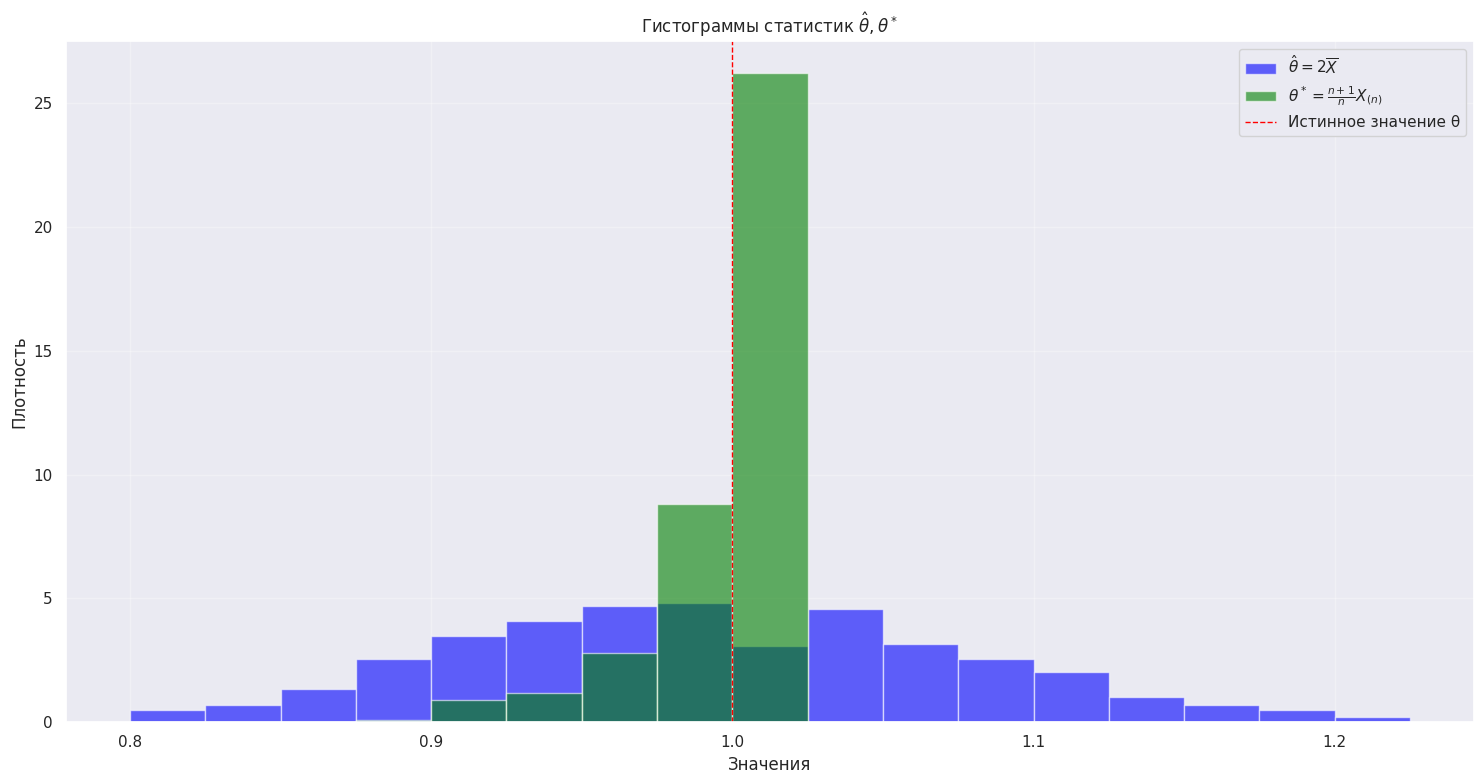

     Оценка 2*mean  Оценка (n+1)/n * max
0         1.004561              1.011780
1         0.922805              1.003178
2         1.053310              1.006978
3         1.032598              0.997965
4         0.897429              0.982690
..             ...                   ...
395       0.920603              1.015972
396       1.047439              1.024762
397       1.118680              1.020194
398       0.879476              0.969438
399       1.110348              1.013655

[400 rows x 2 columns]


In [49]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps
import pandas as pd

N_samples = 400
n = 40
theta = 1

sample = np.random.uniform(0,theta, size=(N_samples, n))

estimates_a = sample.mean(axis=1) * 2
estimates_b = sample.max(axis=1) * (n + 1) / n

bins = [i / 40 + 0.8 for i in range(18)]

plt.figure(figsize=(15, 8))
plt.title("Гистограммы статистик $\\hat\\theta, \\theta^*$")
plt.xlabel("Значения")
plt.ylabel("Плотность")

plt.hist(estimates_a, bins=bins, density=True, alpha=0.6, color='blue', label='$\\hat\\theta = 2\\overline{X}$')

plt.hist(estimates_b, bins=bins, density=True, alpha=0.6, color='green', label='$\\theta^* = \\frac{n+1}{n} X_{(n)}$')

plt.axvline(x=theta, color='red', linestyle='dashed', linewidth=1, label='Истинное значение θ')
plt.legend(loc='upper right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

table = pd.DataFrame({
    'Оценка 2*mean': estimates_a,
    'Оценка (n+1)/n * max': estimates_b
})
print(table)


Промоделируйте статистики $\sqrt{n} (\hat\theta - \theta)$ и $1 - n  (\theta^* - \theta)$. К чему сходятся их распределения с ростом $n$?

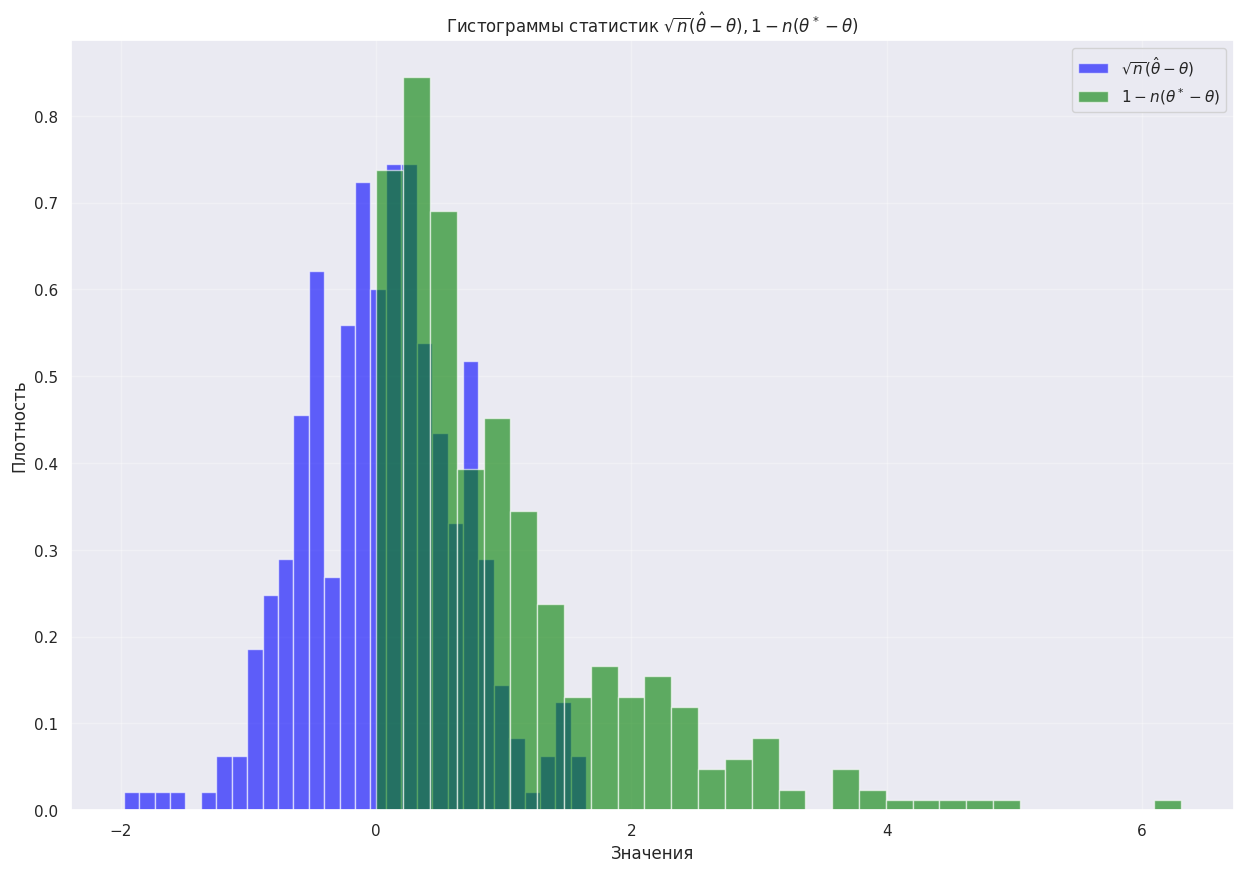

In [58]:
theta_hat = np.sqrt(n) * (estimates_a - theta)
theta_star = (1 - n*(estimates_b - theta))

plt.figure(figsize=(15, 10))
plt.title("Гистограммы статистик $\\sqrt{n} (\\hat\\theta - \\theta), 1 - n(\\theta^* - \\theta)$")
plt.xlabel("Значения")
plt.ylabel("Плотность")

plt.hist(theta_hat, bins=30, density=True, alpha=0.6, color='blue', label='$\\sqrt{n} (\\hat\\theta - \\theta)$')
plt.hist(theta_star, bins=30, density=True, alpha=0.6, color='green', label='$1 - n(\\theta^* - \\theta)$')

plt.legend(loc='upper right')
plt.grid(alpha=0.3)
plt.show()

На какие распределения похожи получившиеся гистограммы?

**Ответ:**
визуально кажется, что зеленый график напоминает экспоненциальное распрредлеение, а синий - нормальное

Вспомните, чему равен коэффициент $\sigma^2(\theta)$ для асимптотически нормальной оценки $\hat\theta = 2\overline{X}$ параметра $\theta$ равномерного распределения в формуле
$$
\sqrt{n}\frac{\left(\hat\theta - \theta\right)}{\sqrt{\sigma^2(\theta)}} \xrightarrow{d} \mathcal N(0, 1).
$$

**Ответ**:
$$\sigma = \frac{\theta}{\sqrt{3}} $$

Посчитайте статистику
$$\sqrt{n}\frac{\left(\hat\theta - \theta\right)}{\sqrt{\sigma^2(\theta)}}$$ для каждой выборки. Постройте её плотность теоретически и при помощи KDE.

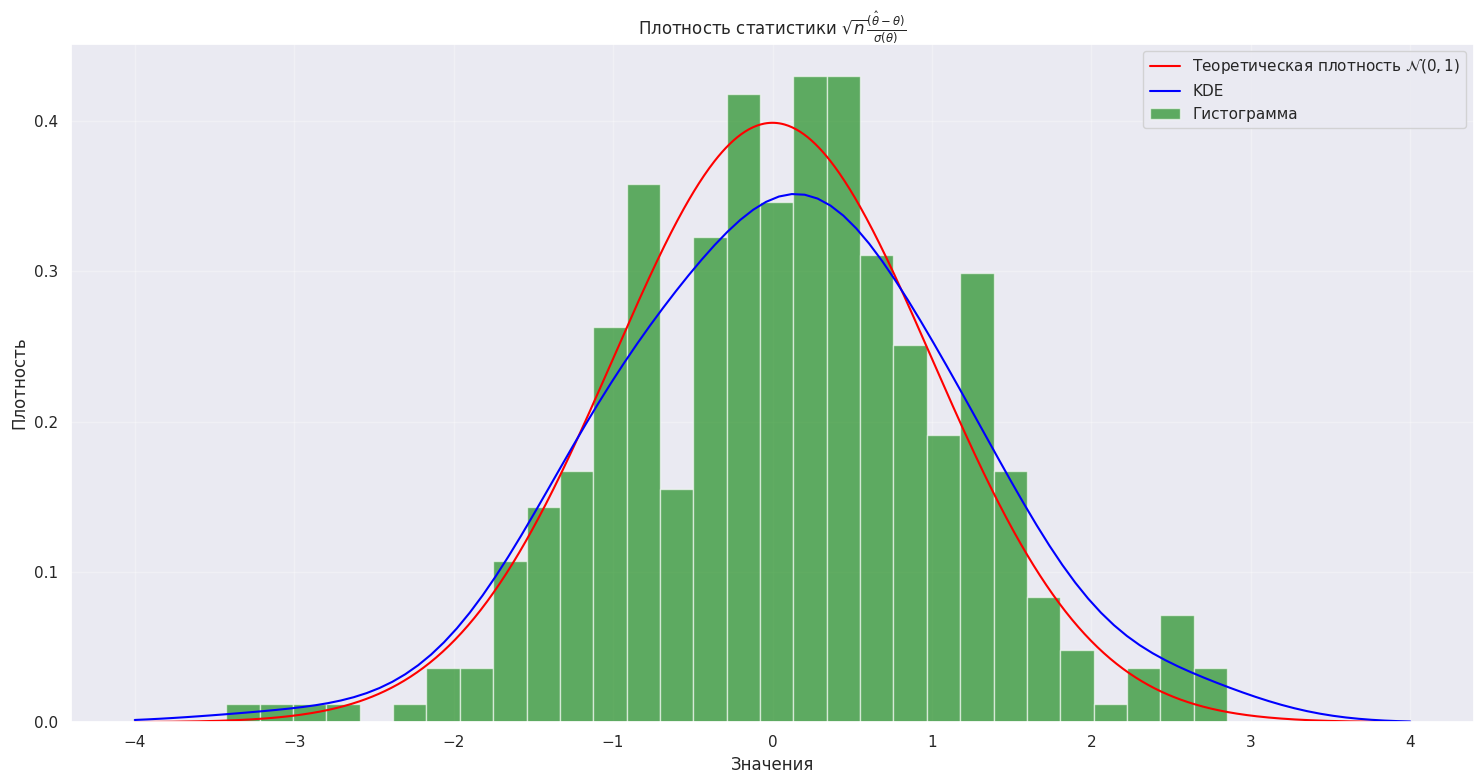

In [62]:
from sklearn.neighbors import KernelDensity

sigma_theta = theta / np.sqrt(3)

sqrt_n_theta_hat_normalized = np.sqrt(n) * (estimates_a - theta) / sigma_theta

plt.figure(figsize=(15, 8))
plt.title("Плотность статистики $\\sqrt{n}\\frac{(\\hat\\theta - \\theta)}{\\sigma(\\theta)}$")
plt.xlabel("Значения")
plt.ylabel("Плотность")

x = np.linspace(-4, 4, 1000)
plt.plot(x, sps.norm.pdf(x), label='Теоретическая плотность $\mathcal{N}(0, 1)$', color='red')

kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(sqrt_n_theta_hat_normalized.reshape(-1, 1))
x_kde = np.linspace(-4, 4, 100)
log_dens = kde.score_samples(x_kde.reshape(-1, 1))
dens = np.exp(log_dens)
plt.plot(x_kde, dens, label='KDE', color='blue')

plt.hist(sqrt_n_theta_hat_normalized, bins=30, density=True, alpha=0.6, label="Гистограмма", color='green')

plt.legend(loc='upper right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

видим, что синяя и красная линия ведут себя очень похоже и имеют почти одинаковые значения, то есть теоретическая плотность почти совпадает с практической

Для быстрой проверки гипотезы о том, что выборка принадлежит какому-либо распределению, часто используется инструмент под названием `QQ-plot` (первые буквы означают `Quantile`). На нем по оси $x$ отложены теоретические значения квантиля, а по оси $y$ -- квантили тестируемой выборки. Очевидно, в идеале такие квантили должны совпадать, поэтому на графике можно увидеть красную линию соответствующую графику функции $y = x$.

Изучите семинарский ноутбук ноль и постройте QQ-plot предложенной статистики и нормального распределения.

<Figure size 1000x600 with 0 Axes>

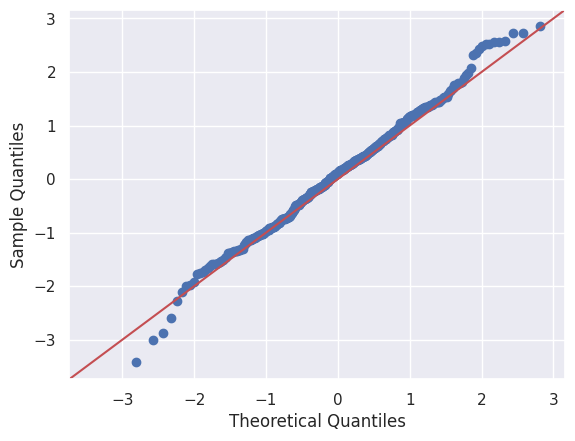

In [75]:
plt.figure(figsize=(10, 6))
sm.qqplot(sqrt_n_theta_hat_normalized, line='45', dist = sps.norm())
plt.show()

Сделайте вывод по графику выше. Можно ли утверждать, что выборка взята из нормального распределения?

**Ответ:**
да, ведь почти на всем множестве точек, наши значения лежат на нужной прямой. таким образом, выборка действительно имеет нормальное распределение

Вернемся к статистике $\theta - n  (\theta^* - \theta)$. Еще раз взгляните на гистограмму, соотвутствующую этой статистике. Попробуйте построить `QQ-plot` для различных распределений (например можно передать в параметр `dist=sps.uniform` в функцию `sm.qqplot` или любое другое из модуля `scipy.stats`). Какое распределение подходит лучше всего?

<Figure size 1000x1000 with 0 Axes>

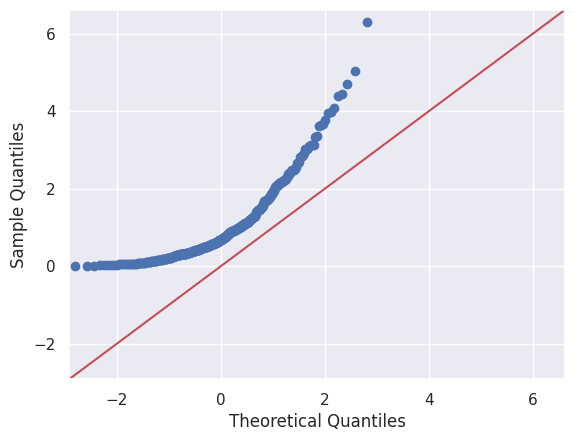

<Figure size 1000x1000 with 0 Axes>

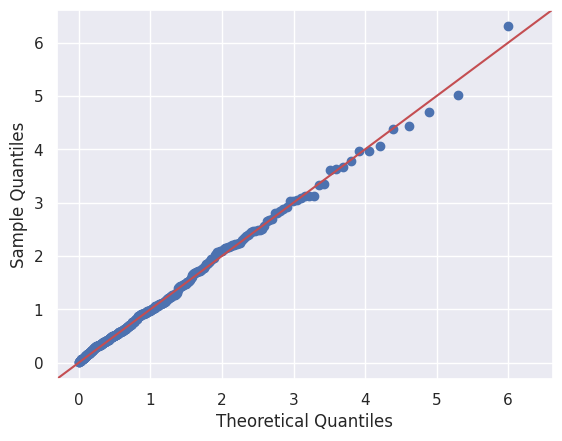

<Figure size 1000x1000 with 0 Axes>

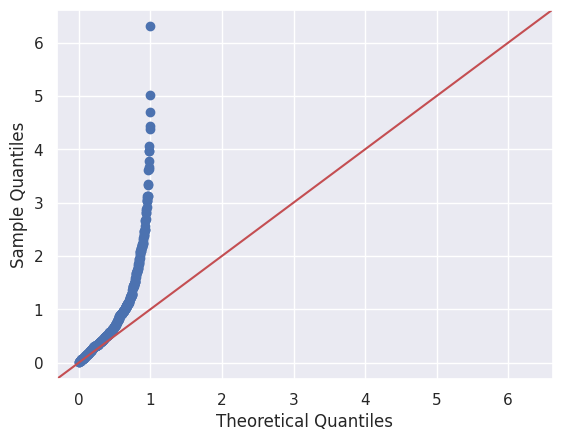

In [72]:
plt.figure(figsize=(10, 6))
sm.qqplot(n_theta_star, line='45', dist = sps.norm())
plt.show()
plt.figure(figsize=(10, 6))
sm.qqplot(n_theta_star, line='45', dist = sps.expon())
plt.show()
plt.figure(figsize=(10, 6))
sm.qqplot(n_theta_star, line='45', dist = sps.uniform)
plt.show()

**Ответ:**
лучше всего себя ведет график с экспоненциальным распределением. на нем почти все точки лежат на прямой. а мы как раз предполагали, что наша оценка имеет экспоненциальное распределение. кайф

Бонусная часть (+5 баллов): Если Вы нашли семейство распределений, которое по QQ-plot соответствует выборке, то докажите строго, что $n(\theta^* - \theta)$ сходится к нему. Заметьте, что это утверждение от асимптотической нормальности отличается только заменой $\sqrt{n}$ на $n$. Такие оценки называются **сверхнормальными**. В конце доказательства поясните:

- как множитель, зависящий от $n$, связан с скоростью сходимости оценки на практике?
- лучше ли сверхномальная оценка, чем нормальная оценка?

**Решение:**

Плохо ли, что оценка $\theta^*$ не асимптотически нормальна? Сделайте вывод о скорости сходимости оценок. Какая из них «выгоднее»?

**Ответ:**

Не забудьте перезапустить с нуля весь ноутбук перед отправкой! Удачи.